In [ ]:
!pip install numpy pandas seaborn matplotlib 
!pip install geopy
!pip install cartopy


!pip install --upgrade scikit-learn imbalanced-learn
!pip install --user --upgrade scikit-learn imbalanced-learn
!pip install --upgrade numpy pandas seaborn matplotlib scikit-learn imbalanced-learn geopy shap

!pip install scikit-learn==1.3.2 imbalanced-learn==0.11.0
!pip install shap

!pip install tensorflow
!pip install optuna

!pip install --upgrade scikit-learn

!pip install pycaret

^C


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import re
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from sklearn.cluster import KMeans
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

from imblearn.over_sampling import SMOTE

from sklearn.dummy import DummyClassifier

import shap

### Analisis inicial

In [2]:
pronostico = pd.read_csv("weatherAUS.csv")

In [3]:
pronostico.info() # 145460

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

1- Date: La fecha en la que se registró.

2- Location: La ciudad en Australia.

3- MinTemp: Temperatura mínima registrada ese día (en grados).

4- MaxTemp: Temperatura máxima registrada ese día (en grados).

5- Rainfall: Cantidad de lluvia registrada ese día (en mm).

6- Evaporation: Cantidad de agua evaporada ese día (en mm).

7- Sunshine: Número de horas de sol.

8- WindGustDir: Dirección del viento durante la ráfaga más fuerte.

9- WindGustSpeed: Velocidad de la ráfaga de viento más fuerte (en km/h).

10- WindDir9am: Dirección del viento a las 9 de la mañana.

11- WindDir3pm: Dirección del viento a las 3 de la tarde.

12- WindSpeed9am: Velocidad del viento a las 9 de la mañana (en km/h).

13- WindSpeed3pm: Velocidad del viento a las 3 de la tarde (en km/h).

14- Humidity9am: Porcentaje de humedad relativa a las 9 de la mañana (en %).

15- Humidity3pm: Porcentaje de humedad relativa a las 3 de la tarde (en %).

16- Pressure9am: Presión atmosférica a las 9 de la mañana (en hPa).

17- Pressure3pm: Presión atmosférica a las 3 de la tarde (en hPa).

18- Cloud9am: Cobertura de nubes a las 9 de la mañana (en oktas, de 0 a 8).

19- Cloud3pm: Cobertura de nubes a las 3 de la tarde (en oktas, de 0 a 8).

20- Temp9am: Temperatura a las 9 de la mañana (en grados).

21- Temp3pm: Temperatura a las 3 de la tarde (en grados).

22- RainToday: Indica si llovió hoy.

23- RainTomorrow: Variable objetivo que indica si lloverá al día siguiente.

In [4]:
pronostico["Date"] = pd.to_datetime(pronostico["Date"])

### Creacion de columnas nuevas

#### Creacion de columnas de tiempo y categoricas como estacion del año y simplificación de la direccion del viento

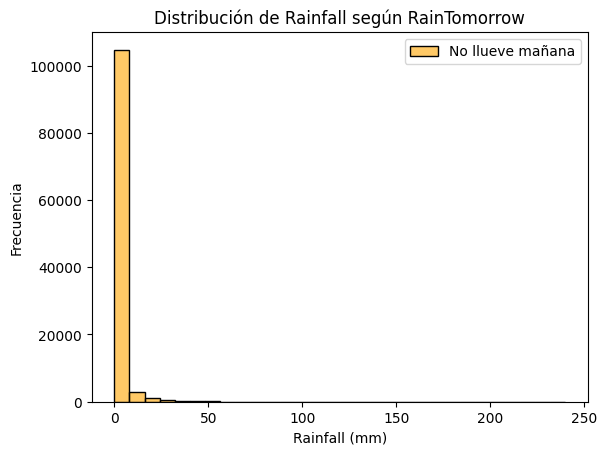

In [5]:
sns.histplot(data=pronostico[pronostico['RainTomorrow'] == "No"],
             x="Rainfall", color="orange", label="No llueve mañana", bins=30, alpha=0.6)
plt.title("Distribución de Rainfall según RainTomorrow")
plt.xlabel("Rainfall (mm)")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

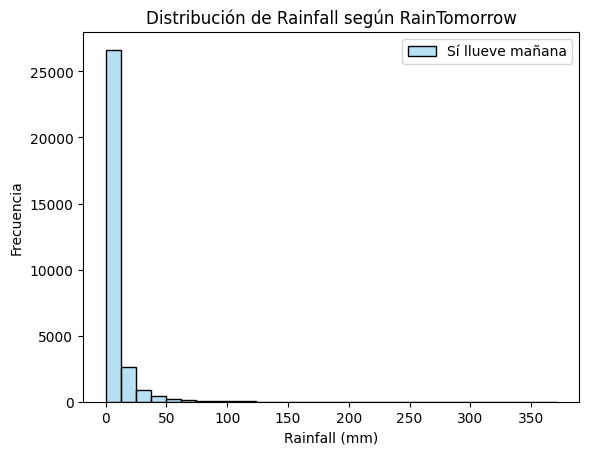

In [6]:
sns.histplot(data=pronostico[pronostico["RainTomorrow"] == "Yes"],
             x="Rainfall", color="skyblue", label="Sí llueve mañana", bins=30, alpha=0.6)

plt.title("Distribución de Rainfall según RainTomorrow")
plt.xlabel("Rainfall (mm)")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

La variable Rainfall, hay que categorizarla, ya que tiene demasiados valores cercanos a 0, donde puede influir a la hora del modelo

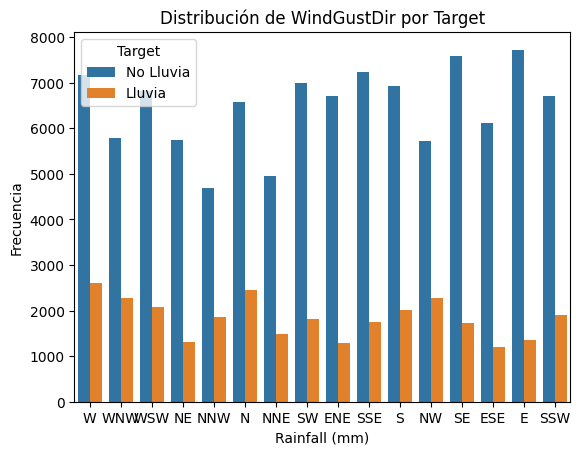

In [7]:
sns.countplot(
    data=pronostico,
    x="WindGustDir",
    hue="RainTomorrow"
)

plt.title("Distribución de WindGustDir por Target")
plt.xlabel("Rainfall (mm)")
plt.ylabel("Frecuencia")
plt.legend(title="Target", labels=["No Lluvia", "Lluvia"])
plt.show()

Aca podemos simplificar la variable de direccion de viento, llevandolas a N, E, O, S, para simplifacar solo en 4 direcciones

In [8]:
# Creamos variables de fecha, para poder mejorar el modelo.

pronostico["dia"] = pronostico["Date"].dt.day
pronostico["mes"] = pronostico["Date"].dt.month
pronostico["año"] = pronostico["Date"].dt.year

In [9]:
def categorizar_rainfall(mm):
    """
    Categorizamos la cantidad de lluvia en mm en diferentes niveles.
    Args:
        mm (float): Cantidad de lluvia en mm.
    Returns:
        str: Categoría de lluvia.
    """
    if mm == 0:
        return 'Ninguna'
    elif mm < 2.5:
        return 'Leve'
    elif mm < 10:
        return 'Moderada'
    else:
        return 'Fuerte'

In [10]:
def simplify_wind_direction(dir):
    """
    Simplifica la dirección del viento a cardinales.
    Args:
        dir (str): Dirección del viento original.
    Returns:
        str: Dirección simplificada (N: Norte, S: Sur, E: Este, O: Oeste, C: Calma).
    """
    if dir in ['N', 'NNE', 'NNW']:
        return 'N'
    elif dir in ['S', 'SSE', 'SSW']:
        return 'S'
    elif dir in ['E', 'ENE', 'ESE']:
        return 'E'
    elif dir in ['W', 'WNW', 'WSW']:
        return 'O'
    else:
        return 'C'

In [11]:
def obtener_estacion_australia(mes, dia):
    """
    Obtenemos la estación del año en Australia según el mes y el día.
    Args:
        mes (int): Mes del año (1-12).
        dia (int): Día del mes (1-31).
    Returns:
        str: Estación del año ('verano', 'otoño', 'invierno', 'primavera').
    """
    if (mes == 12 and dia >= 21) or mes in [1, 2] or (mes == 3 and dia < 21):
        return 'verano'
    elif (mes == 3 and dia >= 21) or mes in [4, 5] or (mes == 6 and dia < 21):
        return 'otoño'
    elif (mes == 6 and dia >= 21) or mes in [7, 8] or (mes == 9 and dia < 21):
        return 'invierno'
    elif (mes == 9 and dia >= 21) or mes in [10, 11] or (mes == 12 and dia < 21):
        return 'primavera'

In [12]:
# Creamos variables, estacion, direccion viento y tipo de lluvia para simplificar la informacion del dataset.

pronostico['Estacion'] = pronostico.apply(lambda row: obtener_estacion_australia(row['mes'], row['dia']), axis=1)
pronostico['Direccion_viento'] = pronostico['WindGustDir'].apply(simplify_wind_direction)
pronostico['WindDir9am'] = pronostico['WindDir9am'].apply(simplify_wind_direction)
pronostico['WindDir3pm'] = pronostico['WindDir3pm'].apply(simplify_wind_direction)
pronostico['Tipo_lluvia'] = pronostico['Rainfall'].apply(categorizar_rainfall) # Consultar si nos quedamos con esta, o con Rainfall

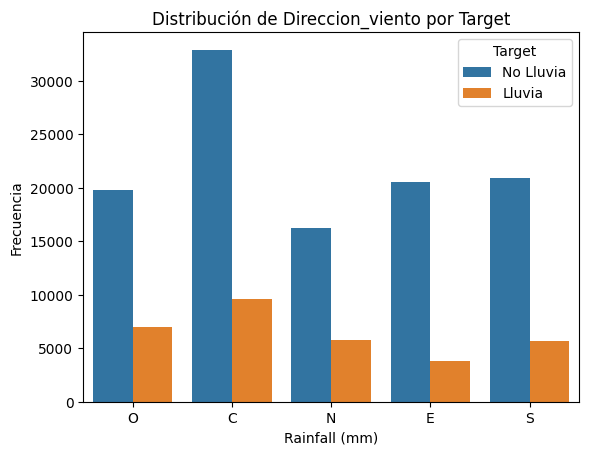

In [13]:
sns.countplot(
    data=pronostico,
    x="Direccion_viento",
    hue="RainTomorrow"
)

plt.title("Distribución de Direccion_viento por Target")
plt.xlabel("Rainfall (mm)")
plt.ylabel("Frecuencia")
plt.legend(title="Target", labels=["No Lluvia", "Lluvia"])
plt.show()

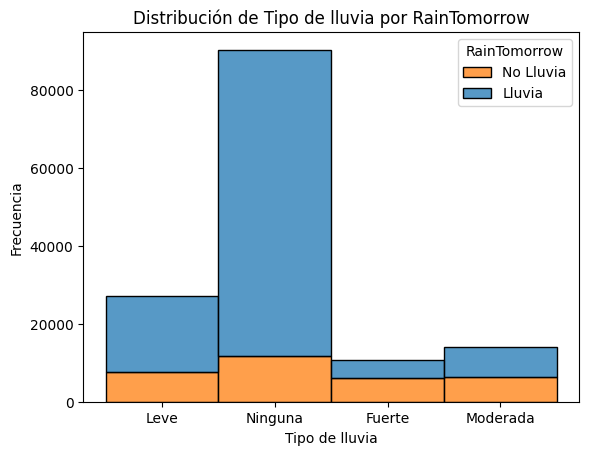

In [14]:
sns.histplot(data=pronostico, x="Tipo_lluvia", hue="RainTomorrow", multiple="stack", bins=30)
plt.title("Distribución de Tipo de lluvia por RainTomorrow")
plt.xlabel("Tipo de lluvia")
plt.ylabel("Frecuencia")
plt.legend(title="RainTomorrow", labels=["No Lluvia", "Lluvia"])
plt.show()

Esto es muchisimo mejor, a la hora de visualizar el tipo de lluvia y la dirección de viento, al simplifarlo queda muchisimo mejor a la hora de utilizarlos en el modelo

#### Creacion de regiones

In [15]:
def formatear_ciudad(nombre):
    """
    Insertar espacios antes de letras mayúsculas intermedias (excepto al principio)
    Args:
        nombre (str): Nombre de la ciudad.
    Returns:
        str: Nombre de la ciudad formateado.
    """
    return re.sub(r'(?<!^)(?=[A-Z])', ' ', nombre).strip()

In [16]:
def obtener_coordenadas(ciudades):
    """
    Recibe una lista o Serie de nombres de ciudades en Australia y devuelve un DataFrame con sus coordenadas geográficas.
    Args:
        ciudades (list or pd.Series): Lista o Serie de nombres de ciudades.
    Returns:
        pd.DataFrame: DataFrame con las ciudades y sus coordenadas (latitud y longitud).
    """
    geolocator = Nominatim(user_agent="geoapi")
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

    excepciones = {
        'Pearce R A A F': 'RAAF Base Pearce, Australia'
    }

    datos = []
    for ciudad in ciudades:
        try:
            if ciudad in excepciones:
                loc = geocode(excepciones[ciudad], timeout=10)
            else:
                loc = geocode(f"{ciudad}, Australia", timeout=10)
            if loc:
                datos.append({'ciudad': ciudad, 'latitud': loc.latitude, 'longitud': loc.longitude})
            else:
                datos.append({'ciudad': ciudad, 'latitud': None, 'longitud': None})
        except:
            datos.append({'ciudad': ciudad, 'latitud': None, 'longitud': None})

    return pd.DataFrame(datos)

In [17]:
# Creamos una lista de ciudades, y obtenemos sus coordenadas.
ciudades = pronostico['Location'].unique()
ciudades = [formatear_ciudad(ciudad) for ciudad in ciudades]
ciudades = obtener_coordenadas(ciudades)

Creamos las variables de Latitud y Longitud, y con dichos datos, utilizamos para obtener por el codo, cual es el mejor numero de cluster para subdividir en regiones.

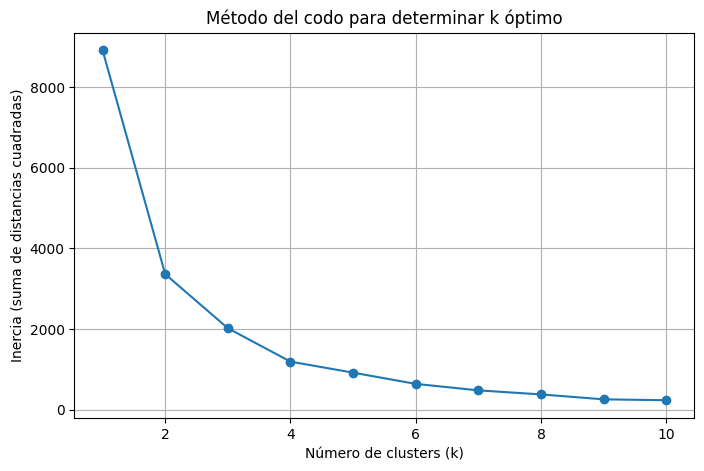

In [18]:
inertias = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(ciudades[['latitud', 'longitud']])
    inertias.append(kmeans.inertia_)

# Graficar el resultado
plt.figure(figsize=(8,5))
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia (suma de distancias cuadradas)')
plt.title('Método del codo para determinar k óptimo')
plt.grid(True)
plt.show()

A partir del grafico, se puede apreciar que el optimo es con 4, ya que despues de ese número deja de cambiar tan drasticamente

##### Grafico de las ciudades

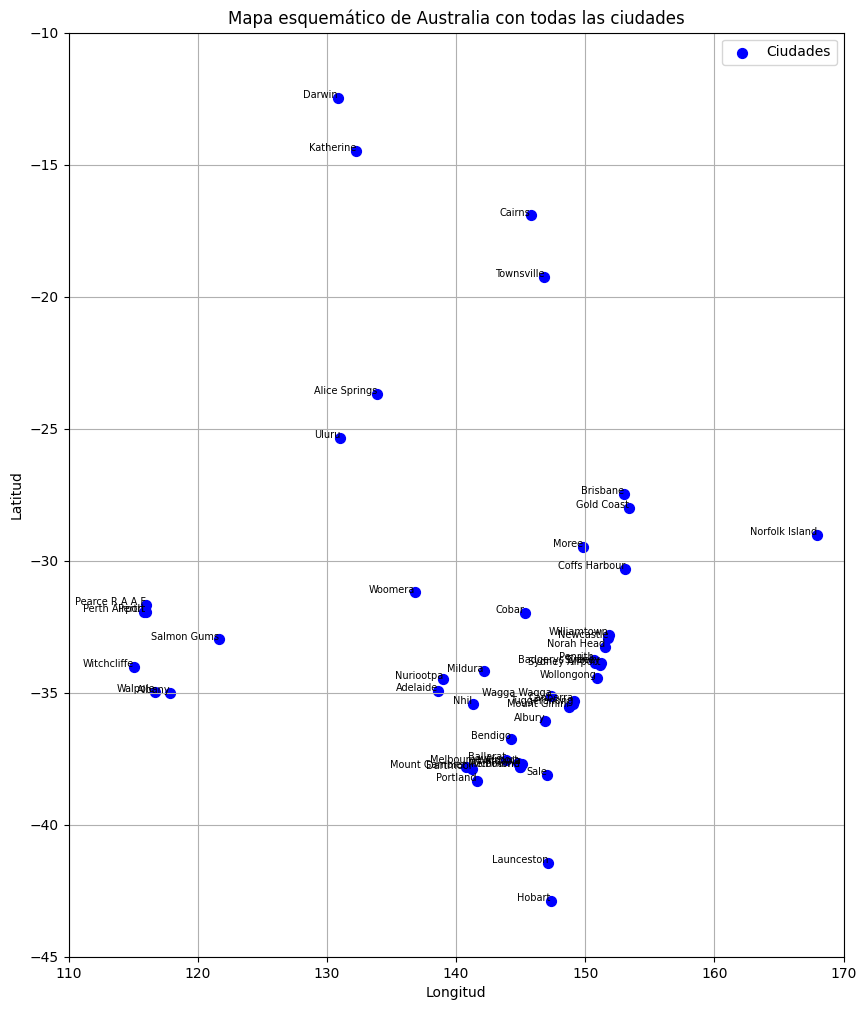

In [19]:
# Creamos un diccionario con la ciudad, y su longitud, para poder graficar.
city_coords = {item[0]: (item[1], item[2]) for item in ciudades.values}
plt.figure(figsize=(10, 12))
plt.scatter(
    [lon for lat, lon in city_coords.values()],
    [lat for lat, lon in city_coords.values()],
    s=50, c='blue', label='Ciudades'
)
for city, (lat, lon) in city_coords.items():
    plt.text(lon, lat, city, fontsize=7, ha='right')

plt.title('Mapa esquemático de Australia con todas las ciudades')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.xlim(110, 170)
plt.ylim(-45, -10)
plt.grid(True)
plt.legend()
plt.show()

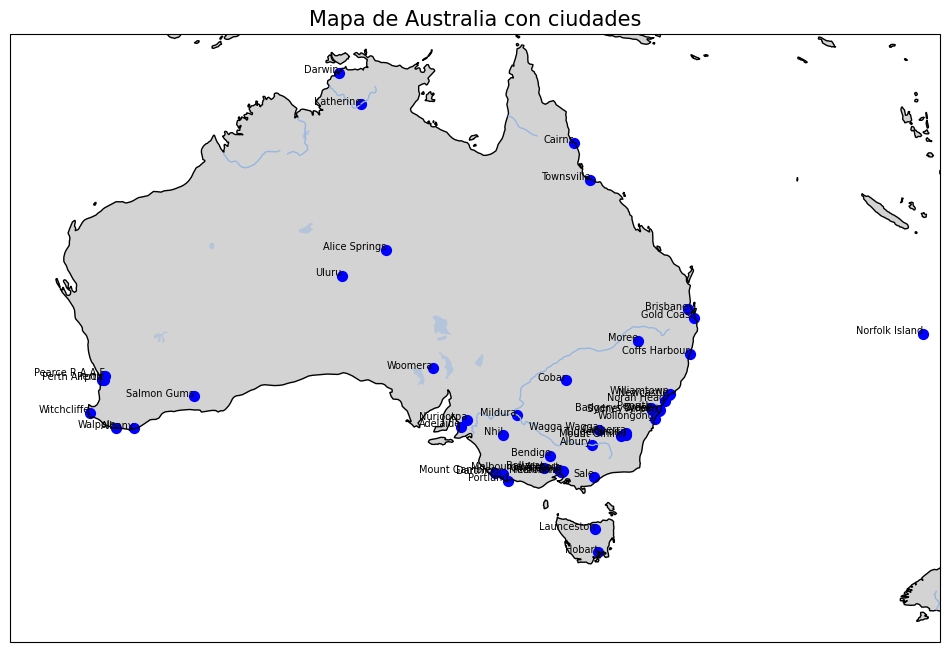

In [20]:
# Mapa hecho con cartopy
plt.figure(figsize=(12, 12))
ax = plt.axes(projection=ccrs.PlateCarree())  # Proyección para coordenadas geográficas
ax.set_extent([110, 169, -45, -10])  # Limites del mapa (longitud mínima, máxima, latitud mínima, máxima)

# Agregar detalles al mapa
ax.add_feature(cfeature.LAND, facecolor='lightgrey')  # Color de la tierra
ax.add_feature(cfeature.COASTLINE)  # Costas
ax.add_feature(cfeature.BORDERS, linestyle=':')  # Fronteras
ax.add_feature(cfeature.LAKES, alpha=0.5)  # Lagos
ax.add_feature(cfeature.RIVERS)  # Ríos

for city, (lat, lon) in city_coords.items():
    plt.scatter(lon, lat, s=50, c='blue', label='Ciudades', transform=ccrs.PlateCarree())
    plt.text(lon, lat, city, fontsize=7, ha='right', transform=ccrs.PlateCarree())

plt.title('Mapa de Australia con ciudades', fontsize=15)
plt.show()

##### Agrupamos por ciudades

In [21]:
k_optimo = 4 # segun el grafico del codo

nombres_regiones = {
    0: 'Norte',
    1: 'Sur',
    2: 'Este',
    3: 'Oeste'
}

kmeans = KMeans(n_clusters=k_optimo, random_state=0)
ciudades['Region'] = kmeans.fit_predict(ciudades[['latitud', 'longitud']])

pronostico['Location'] = pronostico['Location'].apply(lambda x: formatear_ciudad(x))
pronostico = pronostico.merge(ciudades[['ciudad', 'Region']], left_on='Location', right_on='ciudad', how='left')
pronostico.drop(columns=['ciudad'], inplace=True)
pronostico['Region'] = pronostico['Region'].map(nombres_regiones)

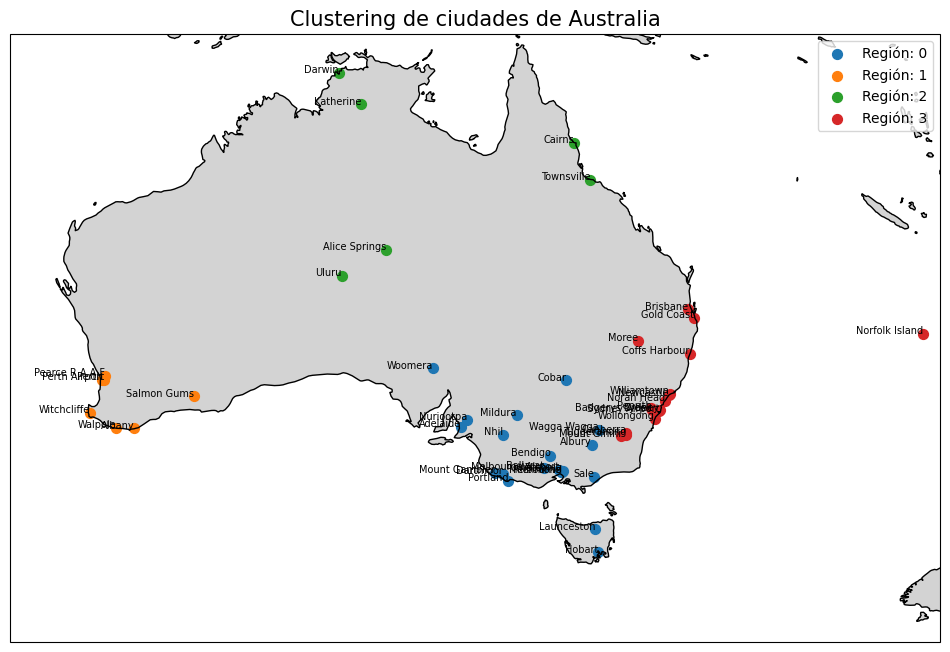

In [22]:
# Configuración del mapa
plt.figure(figsize=(12, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([110, 169, -45, -10])  # Extensión del mapa (longitudes y latitudes de Australia)

# Agregar características al mapa
ax.add_feature(cfeature.LAND, facecolor='lightgrey')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Graficar las ciudades según la región
for region_name, region_id in nombres_regiones.items():
    region_data = ciudades[ciudades['Region'] == region_name]
    plt.scatter(
        region_data['longitud'],
        region_data['latitud'],
        label=f'Región: {region_name}',
        s=50,
        transform=ccrs.PlateCarree()
    )

# Agregar etiquetas de las ciudades
for _, row in ciudades.iterrows():
    plt.text(
        row['longitud'],
        row['latitud'],
        row['ciudad'],
        fontsize=7,
        ha='right',
        transform=ccrs.PlateCarree()
    )

# Configuración del gráfico
plt.title('Clustering de ciudades de Australia', fontsize=15)
plt.legend()
plt.show()


In [23]:
# Verificamos que no haya nulos en la columna RainTomorrow.
print(f"{pronostico['RainTomorrow'].isna().sum()} nulos en nuestra columna objetivo")

#Eliminamos los nulos
pronostico = pronostico.dropna(subset=["RainTomorrow"])

3267 nulos en nuestra columna objetivo


### Division del dataset

In [24]:
# Eliminamos las columnas Date y RainTomorrow, una es la que vamos a predecir y la otra es la no nos sirve para el modelo.
X = pronostico.drop(labels =['Date','RainTomorrow', 'Location', 'WindGustDir'], axis = 1)
y = pronostico['RainTomorrow']

In [25]:
# Ordenar los datos por fecha
pronostico = pronostico.sort_values(by='Date')

# Determinar el índice de corte para dividir en entrenamiento y prueba
train_size = int(len(pronostico) * 0.8)

# Dividir en conjuntos de entrenamiento y prueba
X_train = pronostico.iloc[:train_size].drop(['Date', 'RainTomorrow'], axis=1)
y_train = pronostico.iloc[:train_size]['RainTomorrow']

X_test = pronostico.iloc[train_size:].drop(['Date', 'RainTomorrow'], axis=1)
y_test = pronostico.iloc[train_size:]['RainTomorrow']

### Valores nulos

In [26]:
def calcular_mediana(df : pd.DataFrame, grupo_cols = ['Estacion', 'Region']) -> dict:
    """
    Calcula la mediana de una columna específica en un DataFrame.
    Args:
        df (pd.DataFrame): DataFrame que contiene los datos.
        columna (str): Nombre de la columna para calcular la mediana.
        grupo_cols (list): Lista de columnas por las cuales agrupar los datos antes de calcular la mediana.
    Returns:
        dict: Diccionario con las medianas calculadas para cada grupo.
    """
    medianas = {}
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        medianas[col] = df.groupby(grupo_cols)[col].median()
    return medianas

In [27]:
def calcular_moda (df : pd.DataFrame, grupo_cols = ['Estacion', 'Region']) -> dict:
    """
    Calcula la moda de una columna específica en un DataFrame.
    Args:
        df (pd.DataFrame): DataFrame que contiene los datos.
        columna (str): Nombre de la columna para calcular la moda.
        grupo_cols (list): Lista de columnas por las cuales agrupar los datos antes de calcular la moda.
    Returns:
        dict: Diccionario con las modas de la columna especificada agrupadas por las columnas indicadas.
    """
    modas = {}
    for col in df.select_dtypes(include=['object', 'category']).columns:
        modas[col] = df.groupby(grupo_cols)[col].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    return modas

In [28]:
def rellenar_nulos_numericos(df: pd.DataFrame, medianas: dict, grupo_cols=['Estacion', 'Region']) -> pd.DataFrame:
    """
    Rellena los valores nulos numericos del dataframe con la mediana de la columna, por mes y región.
    Args:
        df (pd.DataFrame): DataFrame con los datos meteorológicos.
    Returns:
        pd.DataFrame: DataFrame con los valores nulos rellenados.
    """

    for col, medianas_col in medianas.items():
        def fill_na(row):
            if pd.isna(row[col]):
                key = tuple(row[grupo_cols])
                return medianas_col.get(key, medianas_col.median())
            else:
                return row[col]
        df[col] = df.apply(fill_na, axis=1)
    return df

In [29]:
def rellenar_nulos_categoricos(df: pd.DataFrame,  modas: dict, grupo_cols=['Estacion', 'Region']) -> pd.DataFrame:
    """
    Rellena los valores nulos categoricos del dataframe con la moda de la columna, por mes y por region.
    Args:
        df (pd.DataFrame): DataFrame con los datos meteorológicos.
    Returns:
        pd.DataFrame: DataFrame con los valores nulos rellenados.
    """
    for col, modas_col in modas.items():
        def fill_na(row):
            if pd.isna(row[col]):
                key = tuple(row[grupo_cols])
                # Buscar moda para el grupo, si no existe usar moda global (opcional)
                return modas_col.get(key, modas_col.mode().iloc[0])
            else:
                return row[col]
        df[col] = df.apply(fill_na, axis=1)
    return df

In [30]:
X_train.isna().sum()

Location                0
MinTemp               469
MaxTemp               223
Rainfall             1128
Evaporation         44361
Sunshine            48542
WindGustDir          7735
WindGustSpeed        7675
WindDir9am              0
WindDir3pm              0
WindSpeed9am         1203
WindSpeed3pm         1400
Humidity9am          1476
Humidity3pm          1695
Pressure9am         11069
Pressure3pm         11034
Cloud9am            41346
Cloud3pm            42639
Temp9am               807
Temp3pm               986
RainToday            1128
dia                     0
mes                     0
año                     0
Estacion                0
Direccion_viento        0
Tipo_lluvia             0
Region                  0
dtype: int64

In [31]:
X_train.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,dia,mes,año
count,113285.000000,113531.000000,112626.000000,69393.000000,65212.000000,106079.000000,112551.000000,112354.000000,112278.000000,112059.000000,102685.000000,102720.000000,72408.000000,71115.000000,112947.000000,112768.000000,113754.000000,113754.000000,113754.000000
mean,11.951064,22.959709,2.345608,5.301313,7.588464,40.063641,14.032714,18.685921,68.815271,51.532380,1017.801118,1015.409600,4.330654,4.430106,16.762038,21.479511,15.702815,6.492985,2011.895889
std,6.371251,7.033272,8.491865,3.989902,3.772434,13.623196,8.957718,8.854735,19.048500,20.729464,7.133546,7.061167,2.877291,2.704055,6.440774,6.873108,8.819406,3.377355,2.064803
min,-8.500000,-4.100000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,979.000000,0.000000,0.000000,-6.200000,-5.100000,1.000000,1.000000,2007.000000
25%,7.400000,17.800000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1013.100000,1010.600000,1.000000,2.000000,12.100000,16.500000,8.000000,4.000000,2010.000000
50%,11.800000,22.300000,0.000000,4.600000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.800000,1015.400000,5.000000,5.000000,16.500000,20.900000,16.000000,7.000000,2012.000000
75%,16.600000,27.900000,0.800000,7.200000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.600000,1020.200000,7.000000,7.000000,21.300000,26.100000,23.000000,9.000000,2014.000000
max,33.900000,48.100000,371.000000,82.400000,14.300000,135.000000,87.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.100000,31.000000,12.000000,2015.000000


In [32]:
medianas = calcular_mediana(X_train)
modas = calcular_moda(X_train)

X_train = rellenar_nulos_numericos(X_train, medianas)
X_train = rellenar_nulos_categoricos(X_train, modas)

X_test = rellenar_nulos_numericos(X_test, medianas)
X_test = rellenar_nulos_categoricos(X_test, modas)


### Graficos

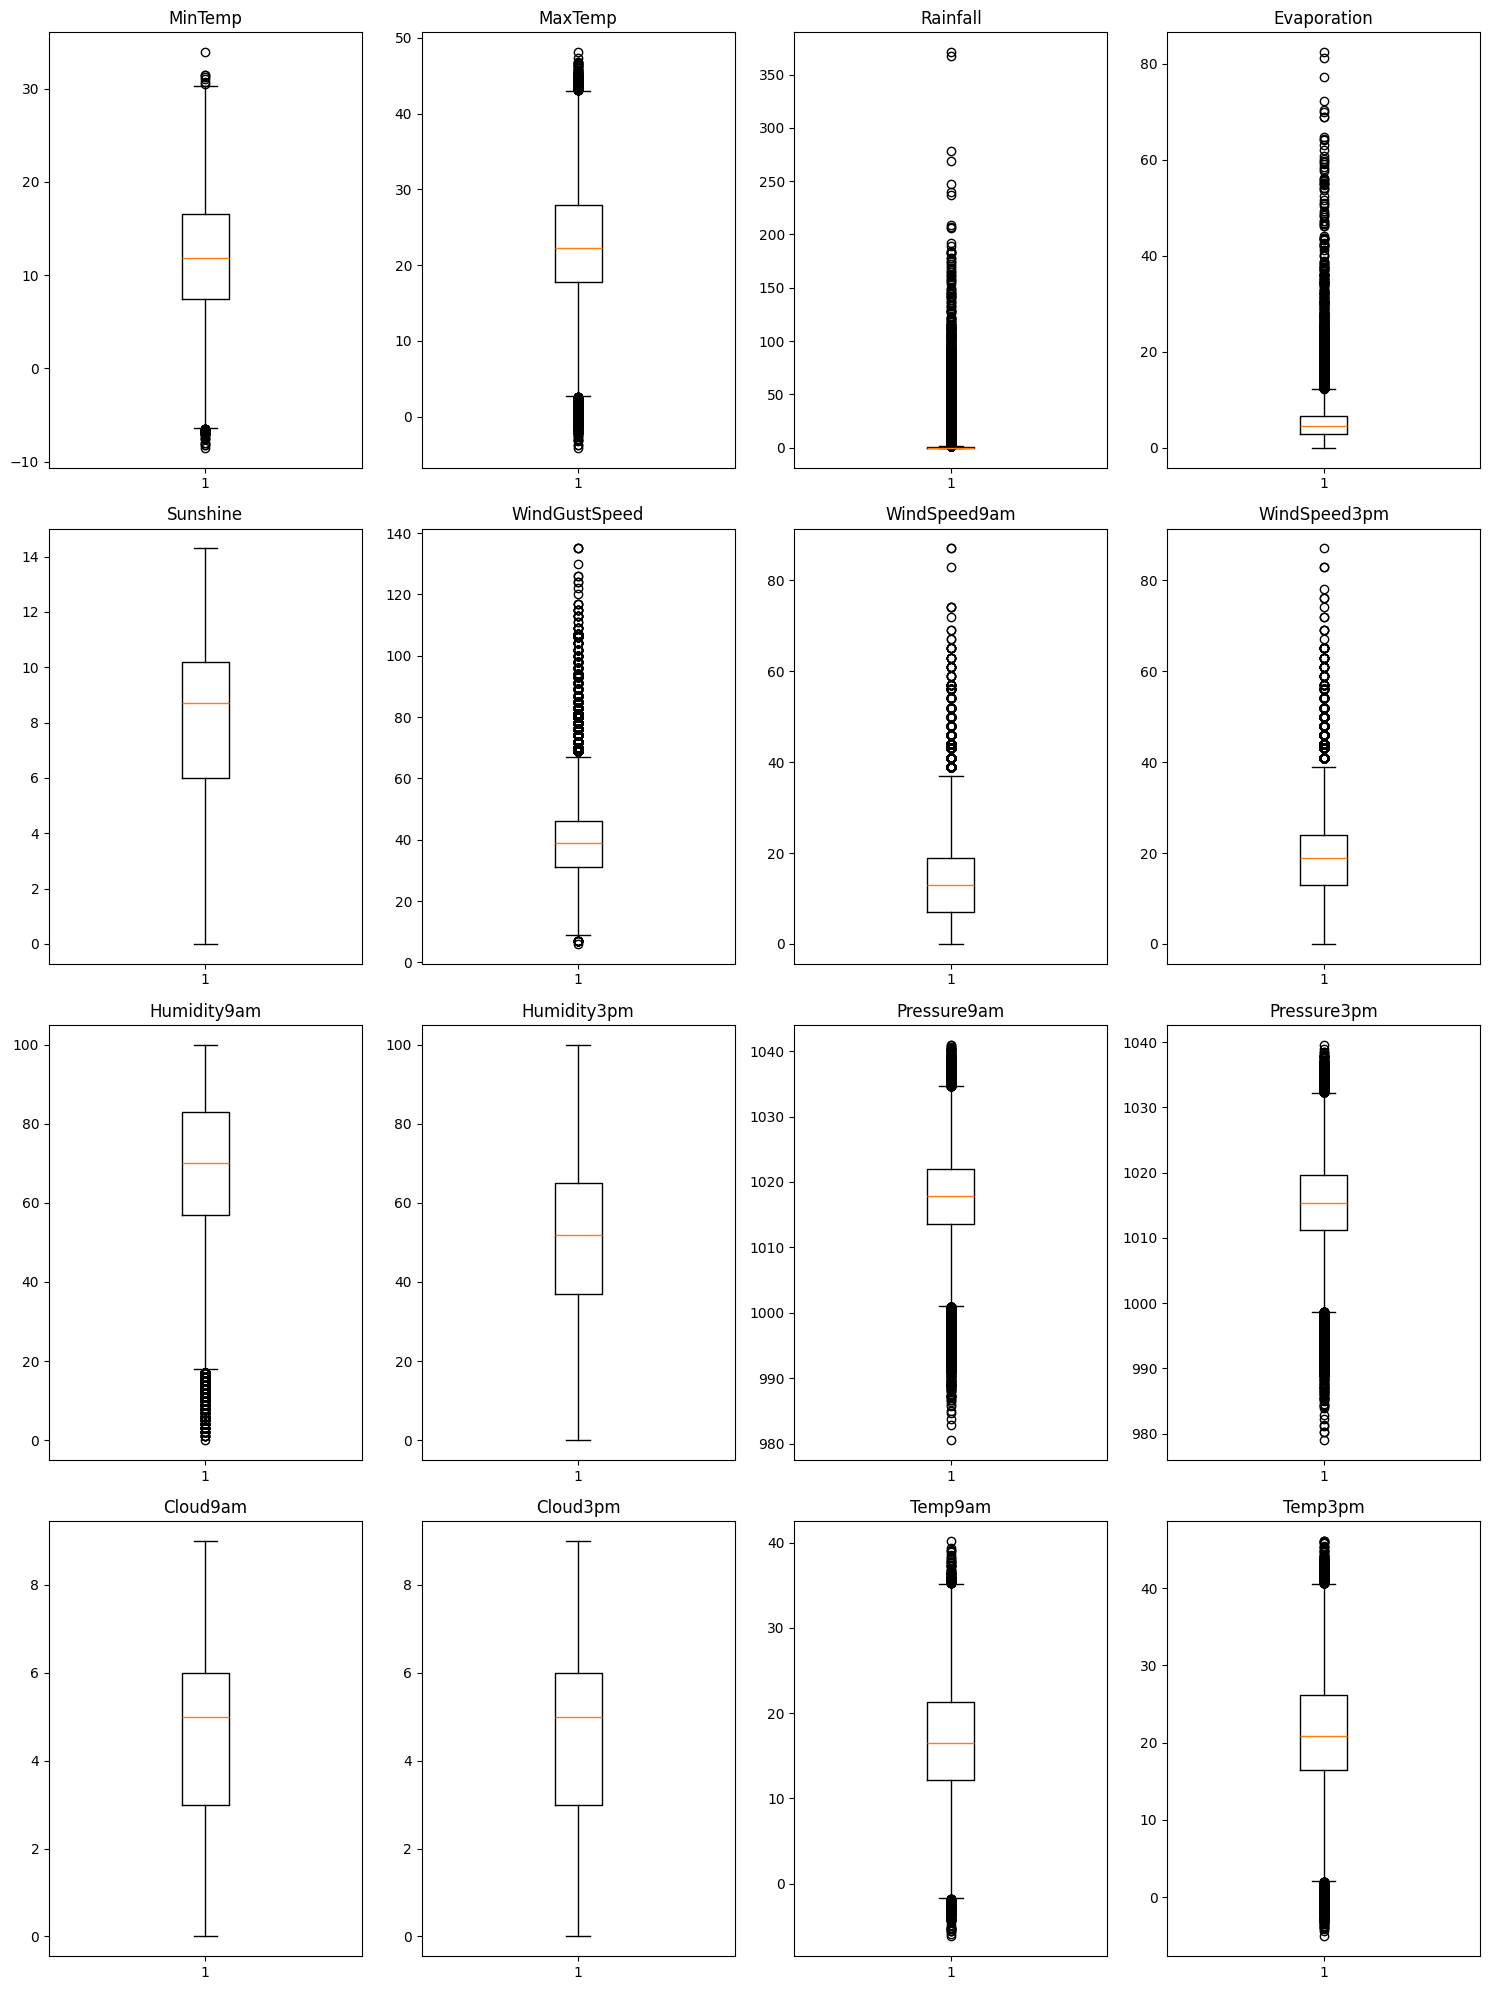

In [33]:
# Boxplots

# Obtenemos las columnas numericos
numericas = list(X_train.select_dtypes(include=['float64', 'int64']).columns)

# Graficamos los boxplot de las columnas numericas
fig, axis = plt.subplots(4, 4, figsize=(15, 20))

# Aplanamos la matriz de subgráficos para facilitar el acceso
axis = axis.flatten()

# Iteramos sobre las columnas numéricas y los subgráficos
for i, columans in enumerate(numericas):
    axis[i].boxplot(X_train[columans])
    axis[i].set_title(columans)

plt.tight_layout()
plt.show()

Se pueden apreciar presencia de valores atipico, pero la mayoria de ellos seria de cuando llueve, y/o relacionadas a otras variables que podrian explicarse. Variables como Evaporation o Rainfall, aparecen que tienen muchisimo valores atipico, pero se pueden explicarse debido a que no siempre llovia.

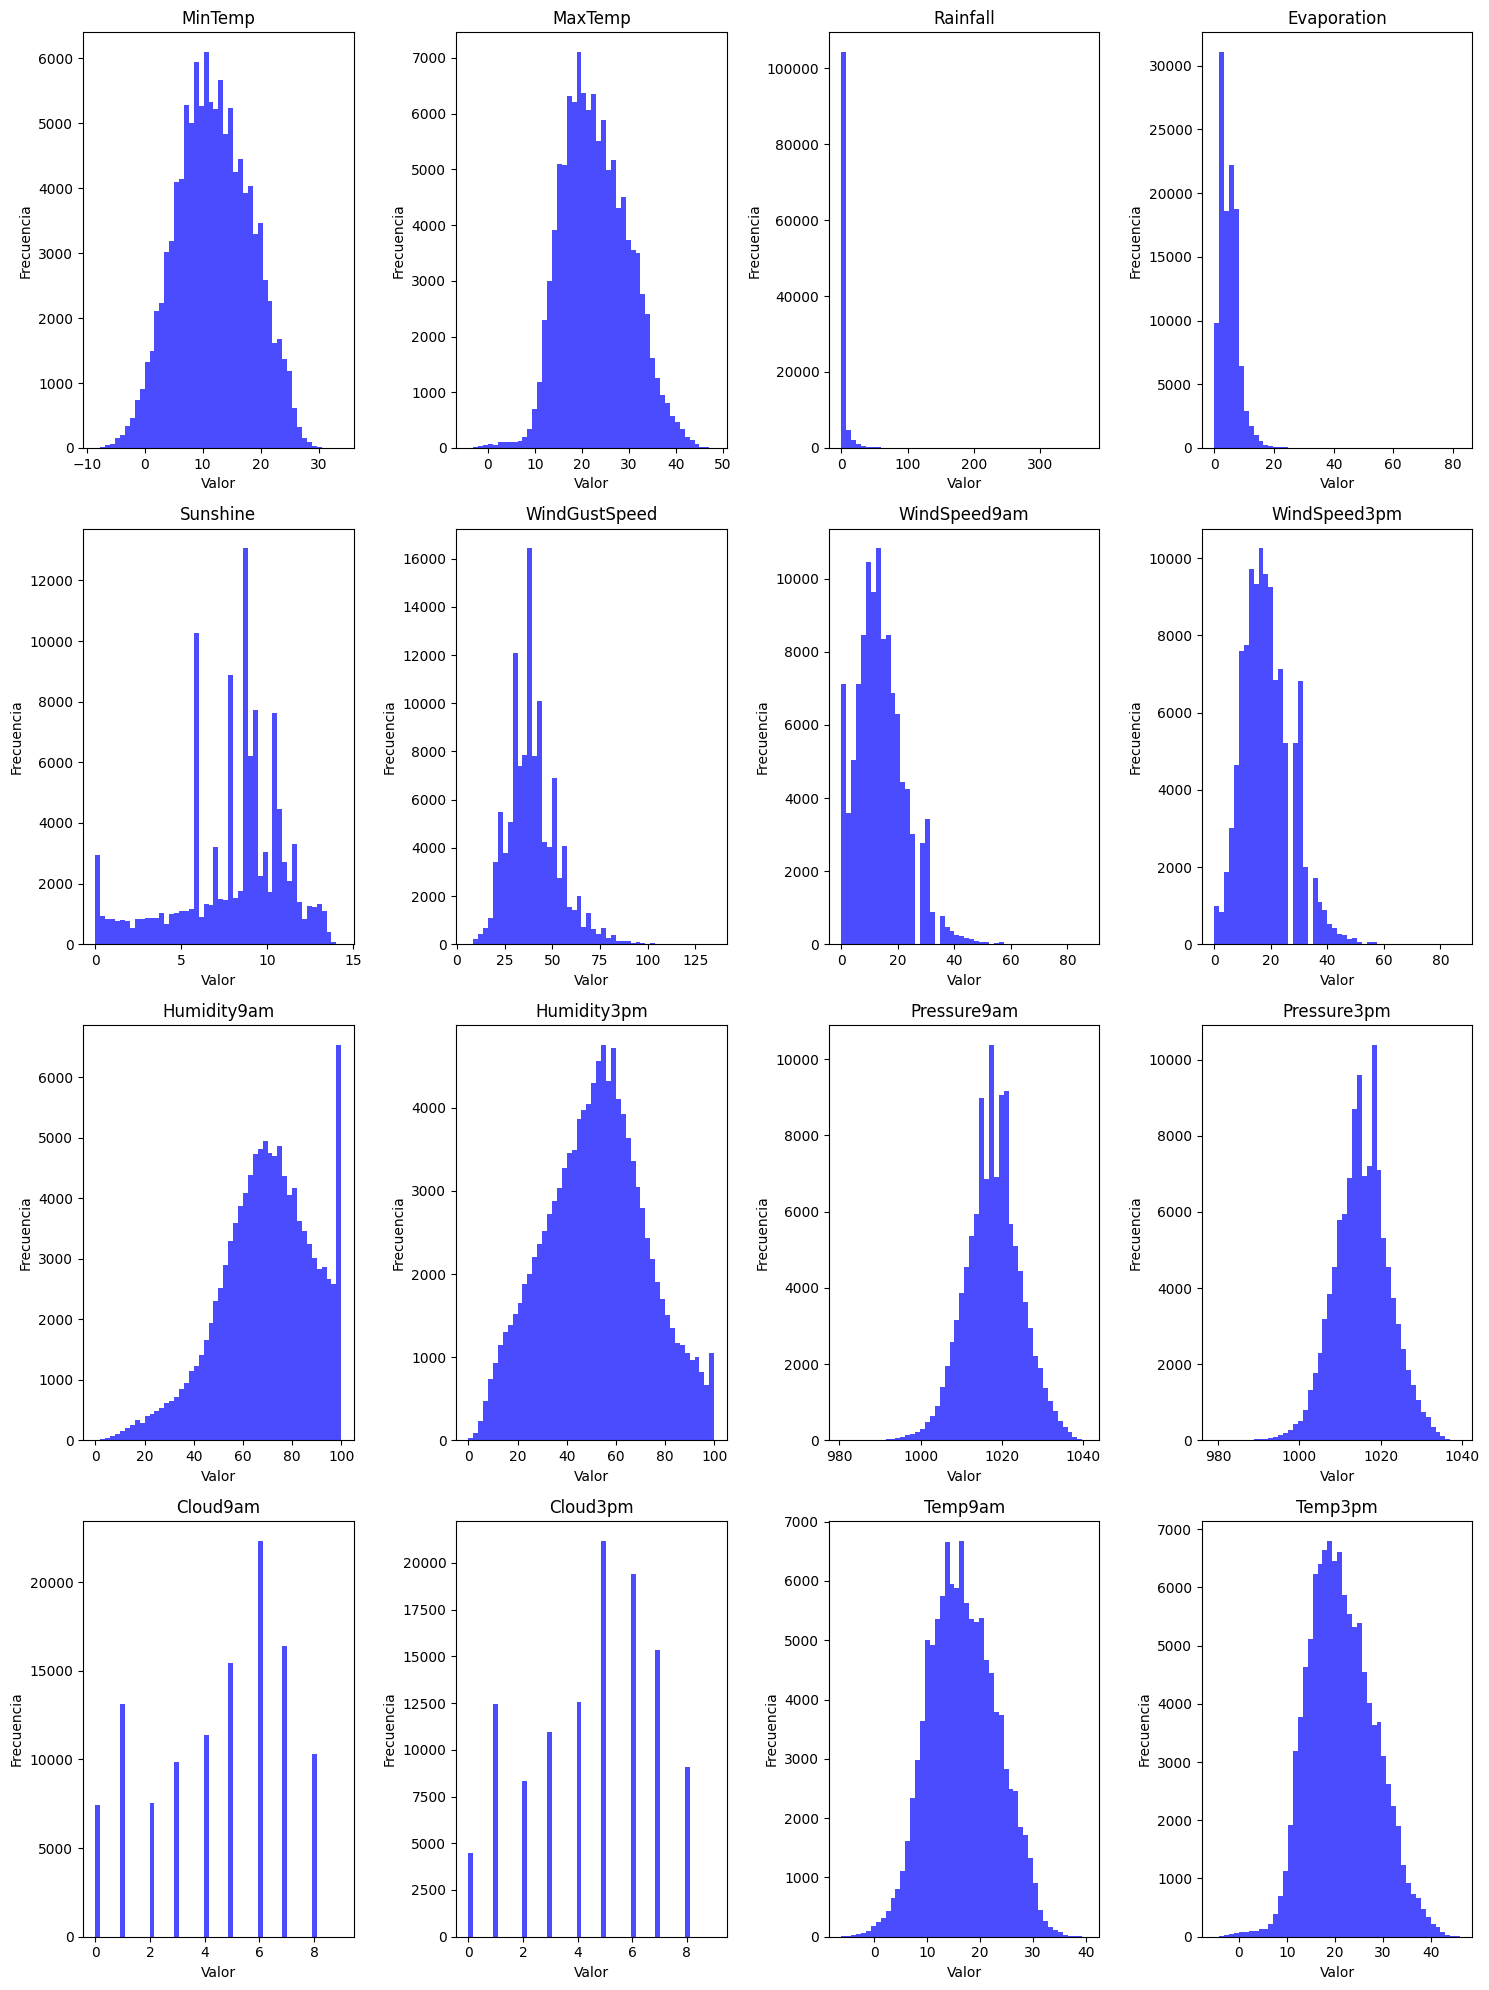

In [34]:
# Histogramas

fig, axis = plt.subplots(4, 4, figsize=(15, 20))

# Aplanamos la matriz de subgráficos para facilitar el acceso
axis = axis.flatten()

# Iteramos sobre las columnas numéricas y los subgráficos

for i, columans in enumerate(numericas):
    axis[i].hist(X_train[columans], bins=50, color='blue', alpha=0.7)
    axis[i].set_title(columans)
    axis[i].set_xlabel('Valor')
    axis[i].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

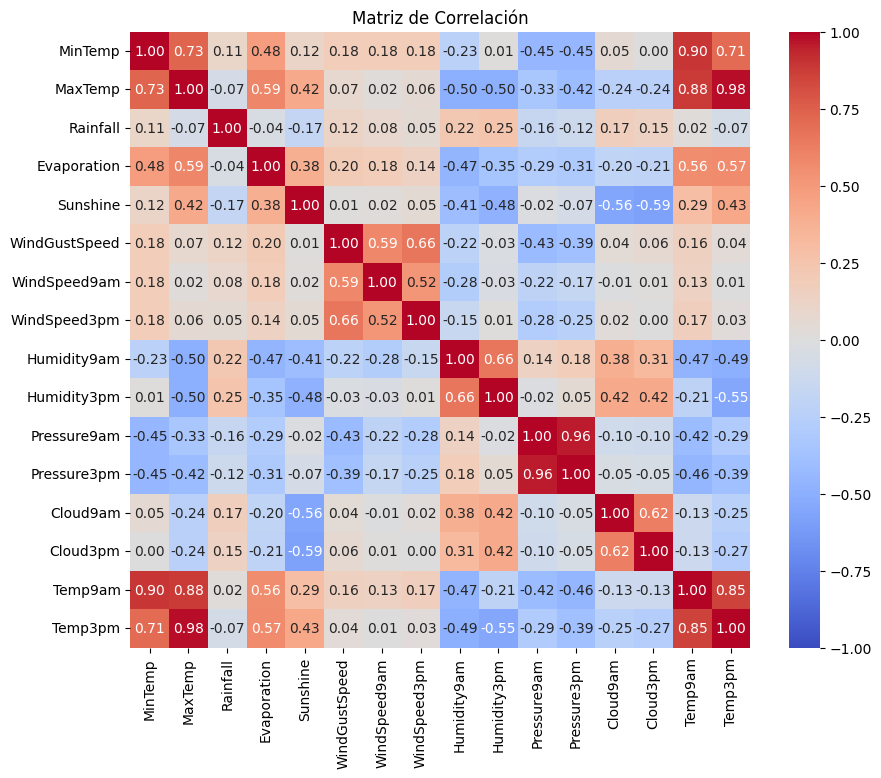

In [35]:
# Matriz de correlación

correlacion = X_train[numericas].corr()

# Visualizamos la matriz de correlación con un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title("Matriz de Correlación")
plt.show()

In [36]:
# Verificamos si la variable target está balanceada
no, si = y_train.value_counts()
total = no + si
print(f"Porcentaje de lluvia: {si/total*100:.2f}%")

Porcentaje de lluvia: 22.44%


Se puede apreciar que se encuentra desbalanciado, con un 22.45% de valores que predicen que va a llover

### Creación de variables dummy

In [37]:
# Codificación de variables categóricas
variables_categoricas = ['Estacion', 'Direccion_viento', 'Tipo_lluvia', 'Region', 'RainToday', 'WindDir9am', 'WindDir3pm']
X_train_cat = pd.get_dummies(X_train[variables_categoricas], drop_first=False)
X_test_cat = pd.get_dummies(X_test[variables_categoricas], drop_first=False)

# Aseguramos que las columnas sean consistentes
X_train_cat, X_test_cat = X_train_cat.align(X_test_cat, join='outer', axis=1, fill_value=0)

### Estandarizacion

In [38]:
numericas = ['MinTemp',
             'MaxTemp',
             'Evaporation', 
             'Sunshine',
             'WindGustSpeed',
             'WindSpeed9am',
             'WindSpeed3pm', 
             'Humidity9am',
             'Humidity3pm',
             'Pressure9am',
             'Pressure3pm',
             'Cloud9am',
             'Cloud3pm',
             'Temp9am',
             'Temp3pm'
             ]

# Estandarización de variables numéricas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numericas])
X_test_scaled = scaler.transform(X_test[numericas])

# Codificación de variables categóricas
variables_categoricas = ['Estacion', 'Direccion_viento', 'Tipo_lluvia', 'Region', 'RainToday', 'WindDir9am', 'WindDir3pm']
X_train_cat = pd.get_dummies(X_train[variables_categoricas], drop_first=False)
X_test_cat = pd.get_dummies(X_test[variables_categoricas], drop_first=False)

# Aseguramos que las columnas sean consistentes
X_train_cat, X_test_cat = X_train_cat.align(X_test_cat, join='outer', axis=1, fill_value=0)

# Convertimos los datos escalados en DataFrames para mantener consistencia con los nombres de columnas
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numericas, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=numericas, index=X_test.index)

# Combinación final
X_train_full = pd.concat([X_train_scaled_df, X_train_cat], axis=1)
X_test_final = pd.concat([X_test_scaled_df, X_test_cat], axis=1)

### Balanceo

In [39]:
X_train_final, y_train_final = SMOTE(random_state=42).fit_resample(X_train_full, y_train)

C:\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


### Entrenamiento del modelo y métricas

In [40]:
# Entrenamos el modelo
modelo = LogisticRegression(random_state=42, max_iter=500)
modelo.fit(X_train_final, y_train_final)

LogisticRegression(max_iter=500, random_state=42)

#### Predicción y matríz de confusión con X_train

              precision    recall  f1-score   support

          No       0.84      0.90      0.87     88224
         Yes       0.89      0.83      0.86     88224

    accuracy                           0.86    176448
   macro avg       0.87      0.86      0.86    176448
weighted avg       0.87      0.86      0.86    176448



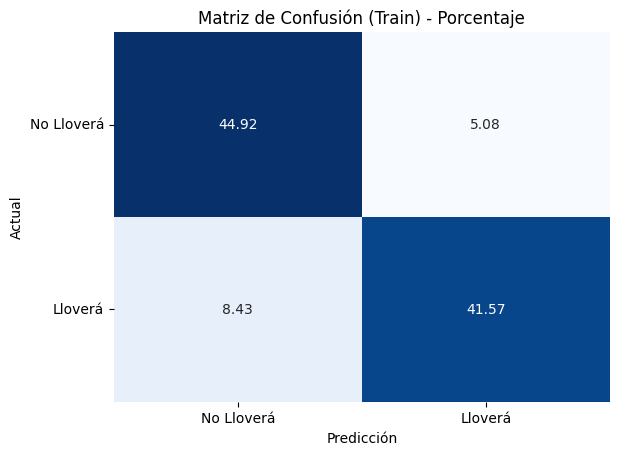

In [41]:
# Generar predicciones para el conjunto de entrenamiento
y_train_pred = modelo.predict(X_train_final)

# Métricas
print(classification_report(y_train_final, y_train_pred))

# Crear la matriz de confusión
conf_matrix_train = confusion_matrix(y_train_final, y_train_pred)

# Convertir los valores en porcentaje
conf_matrix_train_percent = conf_matrix_train / conf_matrix_train.sum() * 100

# Visualizar la matriz de confusión
plt.figure()
sns.heatmap(conf_matrix_train_percent, annot=True, fmt=".2f", cmap="Blues", cbar=False)
plt.title("Matriz de Confusión (Train) - Porcentaje")
plt.xlabel("Predicción")
plt.ylabel("Actual")
plt.xticks(ticks=[0.5, 1.5], labels=['No Lloverá', 'Lloverá'])
plt.yticks(ticks=[0.5, 1.5], labels=['No Lloverá', 'Lloverá'], rotation=0)
plt.show()


#### Predicción y matríz de confusión con X_test

              precision    recall  f1-score   support

          No       0.88      0.91      0.90     22092
         Yes       0.64      0.58      0.61      6347

    accuracy                           0.83     28439
   macro avg       0.76      0.74      0.75     28439
weighted avg       0.83      0.83      0.83     28439



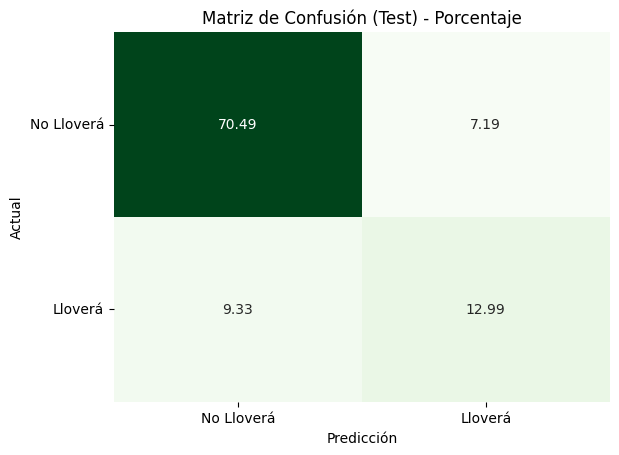

In [42]:
# Predicciones
y_pred = modelo.predict(X_test_final)
y_pred_proba = modelo.predict_proba(X_test_final)[:, 1]

# Métricas básicas
print(classification_report(y_test, y_pred))

# Matriz de confusión
conf_matrix_test = confusion_matrix(y_test, y_pred, labels=['No', 'Yes'])
conf_matrix_test_percent = conf_matrix_test / conf_matrix_test.sum() * 100
sns.heatmap(conf_matrix_test_percent, annot=True, fmt=".2f", cmap="Greens", cbar=False)
plt.title("Matriz de Confusión (Test) - Porcentaje")
plt.xlabel("Predicción")
plt.ylabel("Actual")
plt.xticks(ticks=[0.5, 1.5], labels=['No Lloverá', 'Lloverá'])
plt.yticks(ticks=[0.5, 1.5], labels=['No Lloverá', 'Lloverá'], rotation=0)
plt.show()

#### Analisis de falsos positivos y falsos negativos

Falsos Positivos (7.19%) -> Predicción incorrecta de "Lloverá" cuando realmente "No Lloverá"
Si el costo de emitir una alerta falsa es bajo, este nivel de falsos positivos podría ser aceptable.

Falsos Negativos (9.33%) -> Predicción incorrecta de "No Lloverá" cuando realmente "Lloverá".
No tomar precauciones cuando llueve podría tener un impacto mayor, como daños materiales, cancelación de eventos o riesgos para la población.
Este porcentaje es más crítico, especialmente si las lluvias severas son importantes de predecir en el contexto.

#### Curva ROC

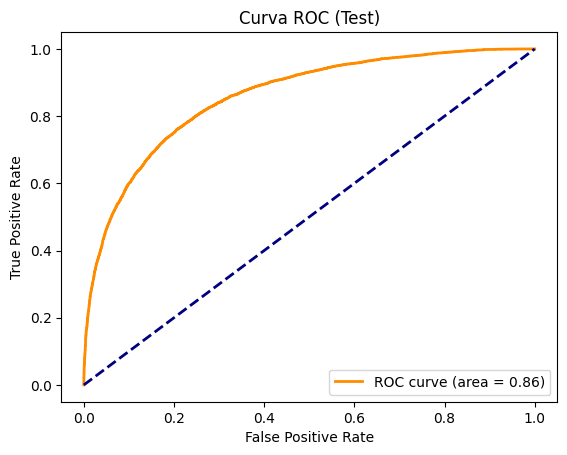

AUC: 0.86
Umbral óptimo: 0.30


In [43]:
# Generar probabilidades de predicción
y_pred_proba_test = modelo.predict_proba(X_test_final)[:, 1]

# Curva ROC para el conjunto de prueba
fpr, tpr, thresholds = roc_curve(y_test.map({'No': 0, 'Yes': 1}), y_pred_proba_test)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC (Test)')
plt.legend(loc="lower right")
plt.show()

# Identificar el umbral óptimo (maximizar TPR - FPR)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"AUC: {roc_auc:.2f}")
print(f"Umbral óptimo: {optimal_threshold:.2f}")


#### Predicción y matríz de confusión con X_test con UMBRAL ÓPTIMO

              precision    recall  f1-score   support

           0       0.92      0.79      0.85     22092
           1       0.51      0.76      0.61      6347

    accuracy                           0.78     28439
   macro avg       0.72      0.78      0.73     28439
weighted avg       0.83      0.78      0.80     28439



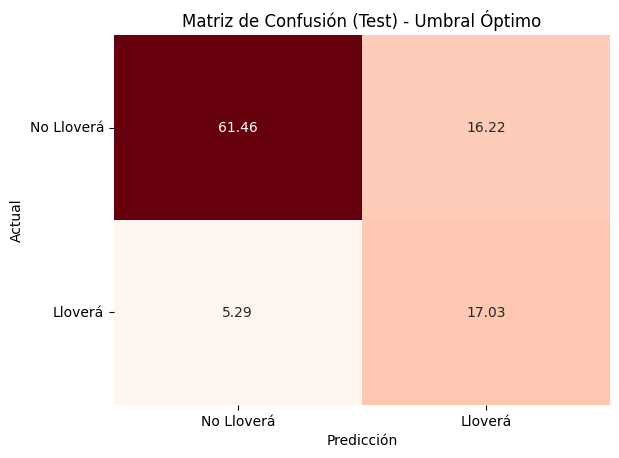

In [44]:
# Usar el umbral óptimo para clasificar
y_pred_optimo = (y_pred_proba_test >= optimal_threshold).astype(int)

# Recalcular métricas con el nuevo umbral
print(classification_report(y_test.map({'No': 0, 'Yes': 1}), y_pred_optimo))

# Calcular la matriz de confusión
conf_matrix_opt = confusion_matrix(y_test.map({'No': 0, 'Yes': 1}), y_pred_optimo)

# Convertir la matriz de confusión a porcentajes
conf_matrix_opt_percent = conf_matrix_opt / conf_matrix_opt.sum() * 100

# Graficar la matriz de confusión
plt.figure()
sns.heatmap(conf_matrix_opt_percent, annot=True, fmt=".2f", cmap="Reds", cbar=False)
plt.title("Matriz de Confusión (Test) - Umbral Óptimo")
plt.xlabel("Predicción")
plt.ylabel("Actual")
plt.xticks(ticks=[0.5, 1.5], labels=['No Lloverá', 'Lloverá'])
plt.yticks(ticks=[0.5, 1.5], labels=['No Lloverá', 'Lloverá'], rotation=0)
plt.show()

    Los falsos negativos se redujeron...

* El porcentaje de falsos negativos (casos donde predecimos "No Lloverá" y en realidad sí llovió) bajó de 9.33% a 5.29%. Esto es una mejora, especialmente en un contexto donde predecir lluvia erróneamente como ausencia podría tener consecuencias críticas.

* A costa de mejorar la cantidad de falsos negativos, el porcentaje de falsos positivos (predicciones de "Lloverá" cuando realmente no llovió) subió de 7.19% a 16.22%. Este incremento puede ser tolerable dependiendo del contexto del problema, pero es un costo a considerar si las falsas alarmas tienen impacto negativo.

### Modelo base

In [45]:
# X_train_final, y_train_final

modelo_base = DummyClassifier(strategy='uniform', random_state=42)

modelo_base.fit(X_train_final, y_train_final)

# Predicciones del modelo base
y_pred_base = modelo_base.predict(X_test_final)

# Métricas del modelo base

print("Métricas del modelo base:")
print(classification_report(y_test, y_pred_base))


Métricas del modelo base:
              precision    recall  f1-score   support

          No       0.78      0.50      0.61     22092
         Yes       0.22      0.50      0.31      6347

    accuracy                           0.50     28439
   macro avg       0.50      0.50      0.46     28439
weighted avg       0.65      0.50      0.54     28439



#### Matriz de confusion

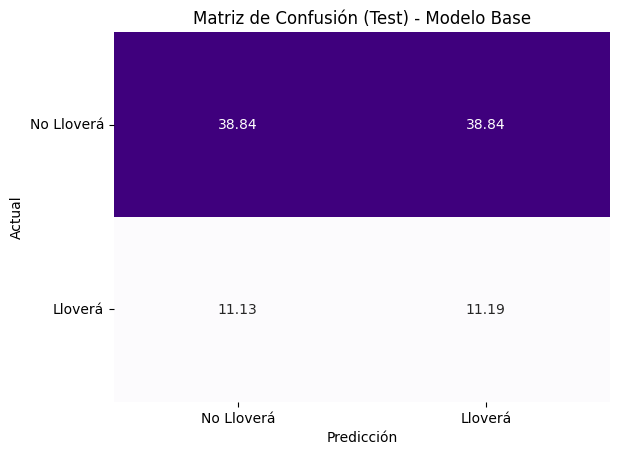

In [46]:
#matriz de confusión del modelo base
conf_matrix_base = confusion_matrix(y_test, y_pred_base, labels=['No', 'Yes'])
conf_matrix_base_percent = conf_matrix_base / conf_matrix_base.sum() * 100

# Graficar la matriz de confusión del modelo base
plt.figure()
sns.heatmap(conf_matrix_base_percent, annot=True, fmt=".2f", cmap="Purples", cbar=False)
plt.title("Matriz de Confusión (Test) - Modelo Base")
plt.xlabel("Predicción")
plt.ylabel("Actual")
plt.xticks(ticks=[0.5, 1.5], labels=['No Lloverá', 'Lloverá'])
plt.yticks(ticks=[0.5, 1.5], labels=['No Lloverá', 'Lloverá'], rotation=0)
plt.show()

#### Curva ROC

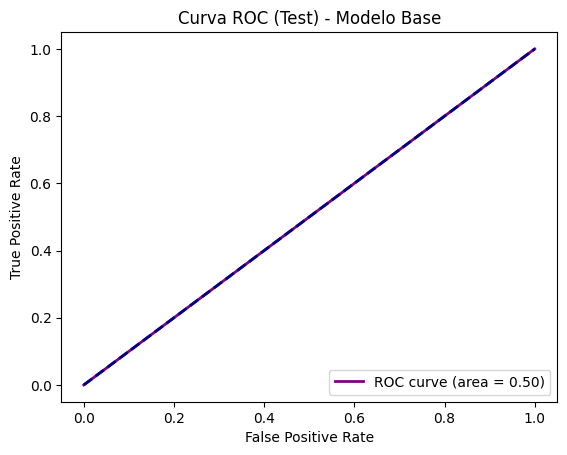

In [47]:
# curva ROC del modelo base

fpr_base, tpr_base, thresholds_base = roc_curve(y_test.map({'No': 0, 'Yes': 1}), modelo_base.predict_proba(X_test_final)[:, 1])
roc_auc_base = auc(fpr_base, tpr_base)
# Graficar la curva ROC del modelo base
plt.figure()
plt.plot(fpr_base, tpr_base, color='purple', lw=2, label=f'ROC curve (area = {roc_auc_base:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC (Test) - Modelo Base')
plt.legend(loc="lower right")
plt.show()

### Optimización de la selección de hiperparámetros:

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Creamos el pipeline primero escalamos y luego entrenar modelo
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(solver='liblinear', max_iter=500))
])

# Definimos los hiperparámetros a optimizar
param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],  # Inverso de L2
    'logreg__penalty': ['l1', 'l2']        # Lasso o Ridge 
}

# Configuramos Grid Search con validación cruzada de 5 folds
grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='accuracy',   
    cv=5,
    verbose=1,
    n_jobs=1  # Desactiva la paralelización
)

# Entrenamos con validación cruzada
grid_search.fit(X_train_full, y_train)

# Mostramos los mejores parámetros y el score asociado
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)
print("Mejor precisión en validación cruzada:", grid_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejores hiperparámetros encontrados: {'logreg__C': 0.01, 'logreg__penalty': 'l1'}
Mejor precisión en validación cruzada: 0.8452713546222578


Usamos GridSearchCV para encontrar los mejores hiperparámetros de Logistic Regression. Para ello, optimizamos el accuracy con una validación cruzada de 5 folds. El mejor modelo resultó con C = 0.01 que indica una fuerte regularización y penalty = 'l1' de Lasso, que implica una penalización más fuerte, que mejora la generalización.

Usamos un Pipeline para escalar las variables con standardScaler y encadenarlas al modelo, así la estandarización se aplica en cada fold de manera correcta evitando fugas de información. Escalamos porque sin escalado, las penalizaciones podrían afectar de forma desbalanceada a las features.

Los hiperparámetros optimizados fueron:

C: El inverso de la fuerza de la regularización. 

penalty: Se comparara L1  y L2. La validación cruzada favoreció L1, indicando que modelos con pocos coeficientes relevantesfuncionan mejor en este conjunto de datos.

Al final, el mejor modelo tuvo un accuracy de validación cruzada del 84.52%, mostrando que se pudo encontrar una configuración que supera a la regresión logística estándar sin regularización ni ajuste fino.

### Implementar explicabilidad de los modelos

* Utilizar SHAP o similar. Implementar al menos dos gráficas a nivel local y dos gráficas a nivel global. ¡Escribir lo que se observa! 
* ¿Cuáles son las variables más importantes? ¿Cuáles son las menos? 

In [49]:
# Crear el explainer para el modelo (depende del tipo de modelo)
explainer = shap.Explainer(modelo, X_test_final, feature_names=X_test_final.columns)

# Calcular valores SHAP para el conjunto de test
shap_values = explainer(X_test_final)

#### Interpretabilidad local

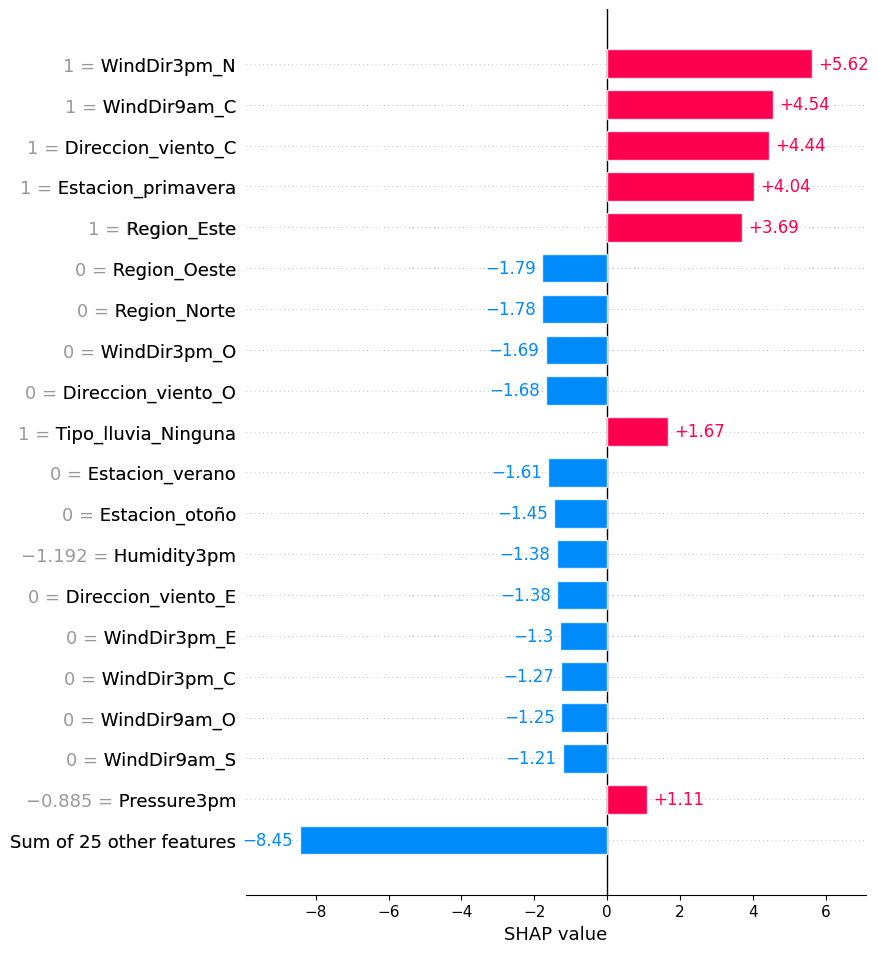

In [50]:
index = 0  # Cambia este índice para ver diferentes instancias
explanation = shap.Explanation(values=shap_values[index],
                               base_values=explainer.expected_value,
                               feature_names=X_test_final.columns)
shap.plots.bar(explanation, max_display=20)

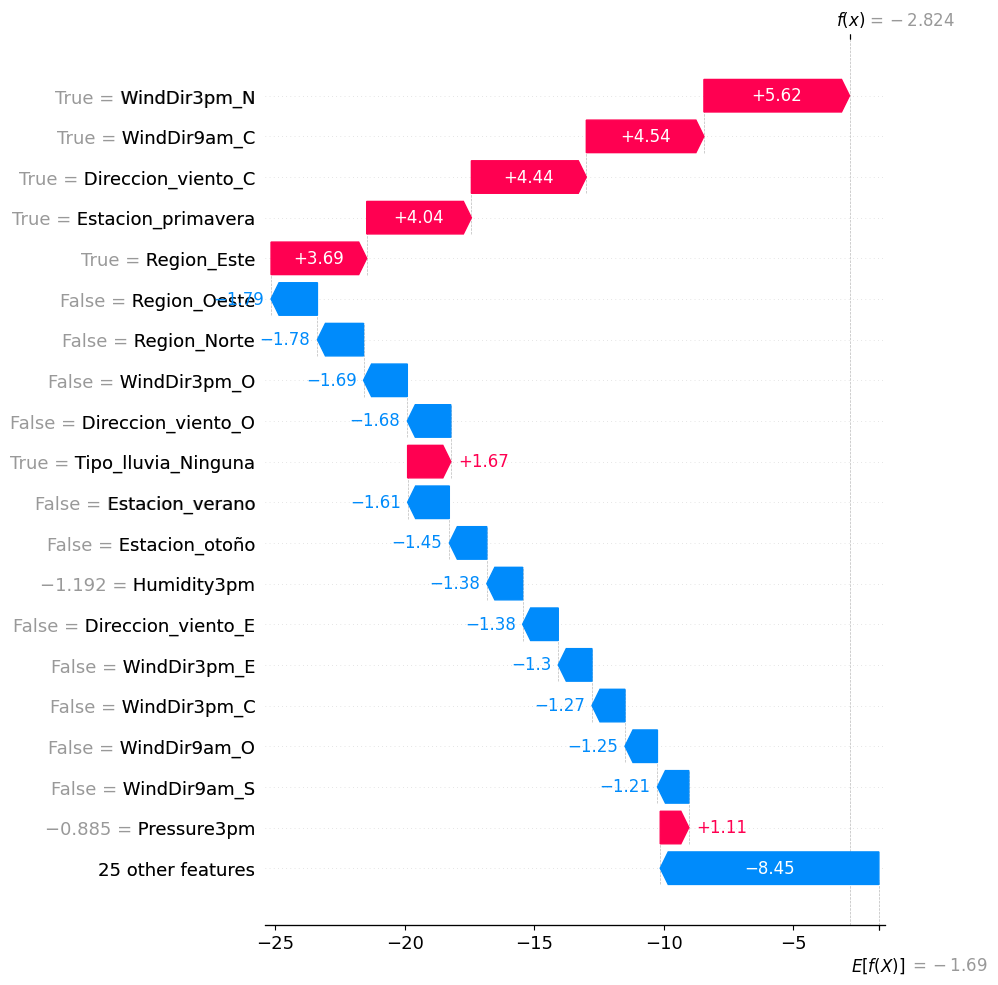

In [51]:
shap.plots.waterfall(explanation,max_display=20)

#### Interpretación global

In [52]:
explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value, feature_names=X_test_final.columns, data=X_test_final)

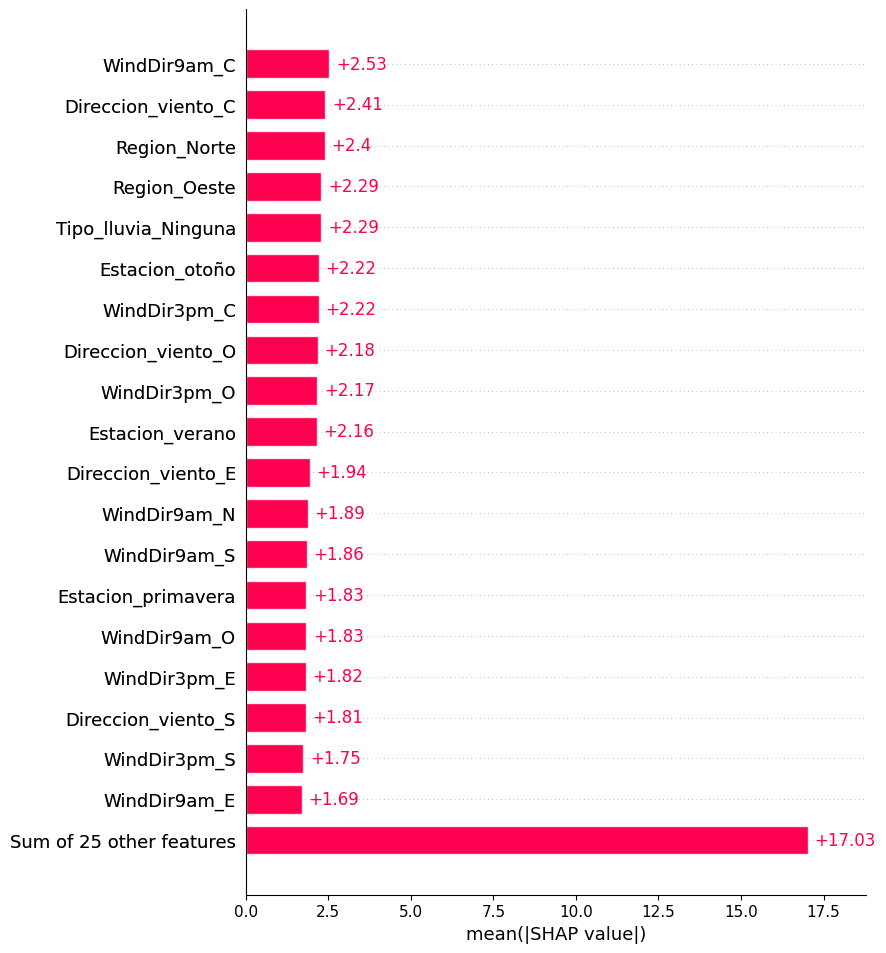

In [53]:
shap.plots.bar(explanation,max_display=20)

### AutoML con PyCaret: 

In [54]:
# Importar PyCaret 
from pycaret.classification import setup, compare_models

ImportError: cannot import name '_print_elapsed_time' from 'sklearn.utils' (C:\anaconda3\envs\tf\lib\site-packages\sklearn\utils\__init__.py)

In [ ]:
# dataframe de entrenamiento con X e y unidos
df_train = X_train_full.copy()
df_train['target'] = y_train

# configurar/inicializar entorno de PyCaret
setup(data=df_train, 
      target='target', 
      session_id=123, 
      normalize=True, 
      verbose=False, 
      use_gpu=False)

# Compararamos todos los modelos de clasificación disponibles
best_model = compare_models()

# detalles de los mejores modelos
print(best_model)


Se puede observar que el mejor modelo obtenido es Light Gradient Boosting Machine (LightGBM) ya que logró el mejor rendimiento en todas las métricas vistas en el proyecto. Tiene un Accuracy de 0.8575 siendo la más alta del ranking, al igual que:

- AUC: 0.8981
- Recall y Precision: ambas en torno a 0.85, lo que indica un buen equilibrio entre la cantidad de positivos detectados y la precisión con la que lo hace
- F1 Score: 0.8487
- Kappa y MCC: también son los más altos, lo que refuerza que el modelo no solo tiene buena precisión sino también un acuerdo general superior considerando clases desbalanceadas

Se observa entonces que el modelo elegido por PyCaret supera al elegido en el proyecto (Logistic Regression) mejorando las métricas.

También se puede notar que el tiempo de entrenamiento de LightGBM es super bajo comparado con otros modelos lo que lo caracteriza como eficiente.

En conclusión PyCaret identificó el mejor modelo de manera automática sin necesidad de hacer una prueba manual de cada uno, lo cual ahorra tiempo y permite hacer un análisis más exhaustivo de más modelos que tal vez no habrían sido probados y eran mejores. 

### Redes neuronales

In [55]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.python.client import device_lib

In [56]:
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


In [57]:
'''
def f1_score(y_true, y_pred):
    y_pred = tf.round(y_pred)  # Convertir probabilidades a 0 o 1
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))  # Verdaderos Positivos
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))  # Falsos Positivos
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32))  # Falsos Negativos
    
    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return f1

def f1_score(y_true, y_pred):
    precision = tf.keras.metrics.Precision()(y_true, y_pred)
    recall = tf.keras.metrics.Recall()(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))
'''

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.tp = self.add_weight(name="tp", initializer="zeros")
        self.fp = self.add_weight(name="fp", initializer="zeros")
        self.fn = self.add_weight(name="fn", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(y_pred)
        self.tp.assign_add(tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32)))
        self.fp.assign_add(tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32)))
        self.fn.assign_add(tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32)))

    def result(self):
        precision = self.tp / (self.tp + self.fp + tf.keras.backend.epsilon())
        recall = self.tp / (self.tp + self.fn + tf.keras.backend.epsilon())
        return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

    def reset_states(self):
        self.tp.assign(0)
        self.fp.assign(0)
        self.fn.assign(0)


In [58]:
class NeuralNetworkTensorFlow:
    def __init__(self, learning_rate=0.01, epochs=100, neurons=96, batch_size=128):
        """
        Inicializa los hiperparámetros del modelo.
        """
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.neurons = neurons
        self.batch_size = batch_size
        self.model = self.build_model()

    def build_model(self):
        """
        Construye el modelo con entrada de 44 características y una salida binaria.
        """
        model = Sequential([
            Dense(self.neurons, activation='relu', input_shape=(44,)),  # Número de neuronas configurable
            Dense(1, activation='sigmoid')  # Salida binaria con sigmoid
        ])
        model.compile(optimizer=Adam(learning_rate=self.learning_rate), 
                      loss='binary_crossentropy', 
                      metrics=['accuracy', F1Score()])
        print("n° de parámetros:", model.count_params())
        return model

    def fit(self, X, y):
        """
        Entrena el modelo con los datos proporcionados.
        """
        X = np.array(X, dtype=np.float32)  # Convertir X a float32
        y = np.array(y, dtype=np.float32)  # Convertir y a float32
        
        # Contexto explícito para usar la GPU
        with tf.device('/GPU:0'):  # Usar GPU 0 (primera GPU disponible)
            history = self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=1)  # Tamaño de batch configurable
        
        return history.history

    def predict(self, X):
        """
        Genera predicciones a partir del modelo entrenado.
        """
        X = np.array(X, dtype=np.float32)
        with tf.device('/GPU:0'):
            predictions = self.model.predict(X)
        return (predictions > 0.5).astype(int)  # Convertir probabilidades a 0 o 1


In [59]:
X_train_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113754 entries, 45587 to 101959
Data columns (total 44 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   MinTemp               113754 non-null  float64
 1   MaxTemp               113754 non-null  float64
 2   Evaporation           113754 non-null  float64
 3   Sunshine              113754 non-null  float64
 4   WindGustSpeed         113754 non-null  float64
 5   WindSpeed9am          113754 non-null  float64
 6   WindSpeed3pm          113754 non-null  float64
 7   Humidity9am           113754 non-null  float64
 8   Humidity3pm           113754 non-null  float64
 9   Pressure9am           113754 non-null  float64
 10  Pressure3pm           113754 non-null  float64
 11  Cloud9am              113754 non-null  float64
 12  Cloud3pm              113754 non-null  float64
 13  Temp9am               113754 non-null  float64
 14  Temp3pm               113754 non-null  float64
 15  E

In [60]:
y_train

45587     Yes
45588     Yes
45589     Yes
45590     Yes
45591      No
         ... 
98919      No
44993      No
135477    Yes
92686      No
101959    Yes
Name: RainTomorrow, Length: 113754, dtype: object

In [61]:
bool_columns = X_train_full.select_dtypes(include=['bool']).columns

# Convertir booleanos a números
X_train_full[bool_columns] = X_train_full[bool_columns].astype(float)

# Convertir los float64 a float32 para un mejor funcionamiento de la red neuronal
X_train_full = X_train_full.astype(np.float32)

# Convierto los bool de y_train en 1 o 0 y despues los paso a float32
y_train = y_train.map({'Yes': 1, 'No': 0})
y_train = y_train.astype(np.float32)

In [62]:
# Entrenar el modelo
nn_tensorflow = NeuralNetworkTensorFlow(learning_rate=0.001, epochs=50)
loss_history = nn_tensorflow.fit(X_train_full, y_train)  # X_train_full, y_train

n° de parámetros: 4417
Epoch 1/50
889/889 [==============================] - 4s 3ms/step - loss: 0.3584 - accuracy: 0.8426 - f1_score: 0.5904
Epoch 2/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3357 - accuracy: 0.8542 - f1_score: 0.6275
Epoch 3/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3304 - accuracy: 0.8557 - f1_score: 0.6332
Epoch 4/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3274 - accuracy: 0.8587 - f1_score: 0.6401
Epoch 5/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3250 - accuracy: 0.8594 - f1_score: 0.6435
Epoch 6/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3230 - accuracy: 0.8604 - f1_score: 0.6470
Epoch 7/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3215 - accuracy: 0.8605 - f1_score: 0.6475
Epoch 8/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3203 - accuracy: 0.8617 - f1_score: 0.6501
Epoch 9/50
889/889 [=====

In [63]:
from sklearn.metrics import log_loss

# Probabilidades predichas por el modelo de regresión logística
y_proba_logistica = modelo.predict_proba(X_test_final)

# Calculamos la pérdida de entropía cruzada
logistic_loss = log_loss(y_test, y_proba_logistica)

print(f"Loss del modelo de regresión logística: {logistic_loss:.4f}")

Loss del modelo de regresión logística: 0.3771


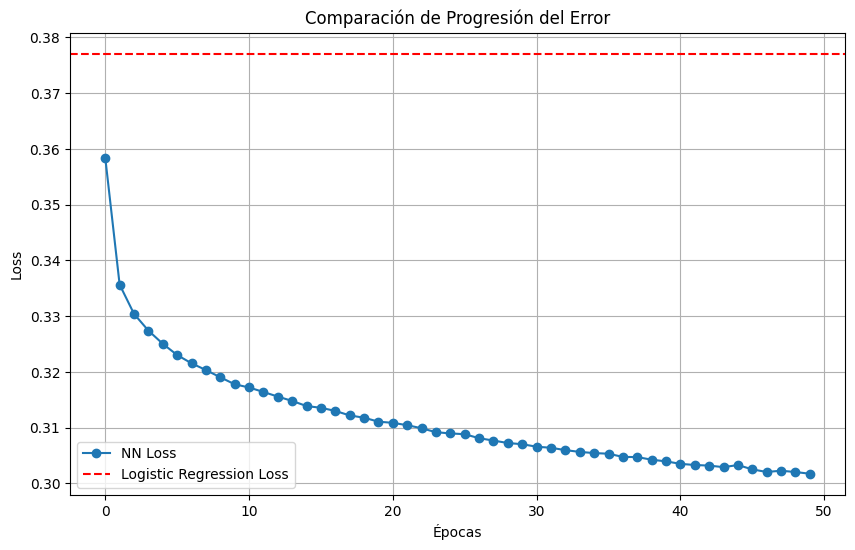

In [64]:
# Extraer los valores de pérdida
nn_loss = loss_history['loss']  # Pérdida de la red neuronal

# Crear el gráfico
plt.figure(figsize=(10, 6))
plt.plot(nn_loss, label='NN Loss', marker='o')  # Progresión de la pérdida de la red neuronal
plt.axhline(logistic_loss, color='red', label='Logistic Regression Loss', linestyle='--')  # Línea horizontal para el modelo logístico

# Configurar el gráfico
plt.title('Comparación de Progresión del Error')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [65]:
predictions = nn_tensorflow.predict(X_test_final)
# print("Predicciones:", predictions)

889/889 [==============================] - 1s 859us/step


### Variación de hiperparametros con Optuna

In [66]:
import optuna

In [69]:
def objective(trial):
    # Definir hiperparámetros a optimizar
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
    neurons = trial.suggest_categorical('neurons', [32, 64, 96])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    
    # Crear y entrenar el modelo con los hiperparámetros
    nn_model = NeuralNetworkTensorFlow(learning_rate=learning_rate, epochs=50)
    history = nn_model.fit(X_train_full, y_train)
    
    # Retornar el máximo accuracy alcanzado
    return max(history["accuracy"])

# Ejecutar la optimización con Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Resultados
print("Mejores hiperparámetros encontrados:", study.best_params)


[I 2025-06-24 02:38:10,102] A new study created in memory with name: no-name-2e6d7f80-8100-491f-b26a-012c810a780a


n° de parámetros: 4417
Epoch 1/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3456 - accuracy: 0.8484 - f1_score: 0.6108
Epoch 2/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3309 - accuracy: 0.8560 - f1_score: 0.6339
Epoch 3/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3266 - accuracy: 0.8584 - f1_score: 0.6403
Epoch 4/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3237 - accuracy: 0.8591 - f1_score: 0.6414
Epoch 5/50
889/889 [==============================] - 2s 3ms/step - loss: 0.3216 - accuracy: 0.8602 - f1_score: 0.6451
Epoch 6/50
889/889 [==============================] - 2s 3ms/step - loss: 0.3190 - accuracy: 0.8617 - f1_score: 0.6491
Epoch 7/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3181 - accuracy: 0.8617 - f1_score: 0.6498
Epoch 8/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3168 - accuracy: 0.8627 - f1_score: 0.6525
Epoch 9/50
889/889 [=====

[I 2025-06-24 02:40:19,822] Trial 0 finished with value: 0.8724792003631592 and parameters: {'learning_rate': 0.0035701312691300306, 'neurons': 64, 'batch_size': 128}. Best is trial 0 with value: 0.8724792003631592.


n° de parámetros: 4417
Epoch 1/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3468 - accuracy: 0.8475 - f1_score: 0.6086
Epoch 2/50
889/889 [==============================] - 2s 3ms/step - loss: 0.3356 - accuracy: 0.8545 - f1_score: 0.6263
Epoch 3/50
889/889 [==============================] - 2s 3ms/step - loss: 0.3315 - accuracy: 0.8559 - f1_score: 0.6307
Epoch 4/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3287 - accuracy: 0.8564 - f1_score: 0.6326
Epoch 5/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3271 - accuracy: 0.8581 - f1_score: 0.6378
Epoch 6/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3249 - accuracy: 0.8592 - f1_score: 0.6405
Epoch 7/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3241 - accuracy: 0.8585 - f1_score: 0.6391
Epoch 8/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3221 - accuracy: 0.8602 - f1_score: 0.6438
Epoch 9/50
889/889 [=====

[I 2025-06-24 02:42:26,091] Trial 1 finished with value: 0.868118941783905 and parameters: {'learning_rate': 0.01161627792517124, 'neurons': 32, 'batch_size': 64}. Best is trial 0 with value: 0.8724792003631592.


n° de parámetros: 4417
Epoch 1/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3492 - accuracy: 0.8483 - f1_score: 0.6082
Epoch 2/50
889/889 [==============================] - 3s 4ms/step - loss: 0.3399 - accuracy: 0.8530 - f1_score: 0.6198
Epoch 3/50
889/889 [==============================] - 3s 4ms/step - loss: 0.3359 - accuracy: 0.8552 - f1_score: 0.6247
Epoch 4/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3343 - accuracy: 0.8554 - f1_score: 0.6262
Epoch 5/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3327 - accuracy: 0.8560 - f1_score: 0.6268
Epoch 6/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3325 - accuracy: 0.8562 - f1_score: 0.6290
Epoch 7/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3309 - accuracy: 0.8566 - f1_score: 0.6303
Epoch 8/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3296 - accuracy: 0.8574 - f1_score: 0.6325
Epoch 9/50
889/889 [=====

[I 2025-06-24 02:44:41,292] Trial 2 finished with value: 0.8608136773109436 and parameters: {'learning_rate': 0.020376888023783672, 'neurons': 32, 'batch_size': 32}. Best is trial 0 with value: 0.8724792003631592.


n° de parámetros: 4417
Epoch 1/50
889/889 [==============================] - 3s 3ms/step - loss: 0.4206 - accuracy: 0.8069 - f1_score: 0.5041
Epoch 2/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3521 - accuracy: 0.8465 - f1_score: 0.5966
Epoch 3/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3456 - accuracy: 0.8493 - f1_score: 0.6089
Epoch 4/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3418 - accuracy: 0.8510 - f1_score: 0.6142
Epoch 5/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3390 - accuracy: 0.8521 - f1_score: 0.6189
Epoch 6/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3368 - accuracy: 0.8538 - f1_score: 0.6242
Epoch 7/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3349 - accuracy: 0.8544 - f1_score: 0.6255
Epoch 8/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3334 - accuracy: 0.8553 - f1_score: 0.6291
Epoch 9/50
889/889 [=====

[I 2025-06-24 02:46:56,809] Trial 3 finished with value: 0.8636267781257629 and parameters: {'learning_rate': 0.00016889211228827454, 'neurons': 64, 'batch_size': 64}. Best is trial 0 with value: 0.8724792003631592.


n° de parámetros: 4417
Epoch 1/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3867 - accuracy: 0.8251 - f1_score: 0.5397
Epoch 2/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3464 - accuracy: 0.8485 - f1_score: 0.6100
Epoch 3/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3407 - accuracy: 0.8514 - f1_score: 0.6200
Epoch 4/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3369 - accuracy: 0.8534 - f1_score: 0.6257
Epoch 5/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3341 - accuracy: 0.8543 - f1_score: 0.6286
Epoch 6/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3318 - accuracy: 0.8558 - f1_score: 0.6331
Epoch 7/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3302 - accuracy: 0.8563 - f1_score: 0.6347
Epoch 8/50
889/889 [==============================] - 4s 4ms/step - loss: 0.3286 - accuracy: 0.8573 - f1_score: 0.6373
Epoch 9/50
889/889 [=====

[I 2025-06-24 02:49:29,238] Trial 4 finished with value: 0.8662376999855042 and parameters: {'learning_rate': 0.00030383627857629884, 'neurons': 96, 'batch_size': 128}. Best is trial 0 with value: 0.8724792003631592.


n° de parámetros: 4417
Epoch 1/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3467 - accuracy: 0.8488 - f1_score: 0.6127
Epoch 2/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3356 - accuracy: 0.8547 - f1_score: 0.6282
Epoch 3/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3321 - accuracy: 0.8557 - f1_score: 0.6299
Epoch 4/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3301 - accuracy: 0.8566 - f1_score: 0.6330
Epoch 5/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3282 - accuracy: 0.8574 - f1_score: 0.6353
Epoch 6/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3266 - accuracy: 0.8582 - f1_score: 0.6377
Epoch 7/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3257 - accuracy: 0.8590 - f1_score: 0.6399
Epoch 8/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3247 - accuracy: 0.8588 - f1_score: 0.6403
Epoch 9/50
889/889 [=====

[I 2025-06-24 02:51:50,866] Trial 5 finished with value: 0.8653937578201294 and parameters: {'learning_rate': 0.013226390642783093, 'neurons': 96, 'batch_size': 128}. Best is trial 0 with value: 0.8724792003631592.


n° de parámetros: 4417
Epoch 1/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3631 - accuracy: 0.8395 - f1_score: 0.5781
Epoch 2/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3374 - accuracy: 0.8533 - f1_score: 0.6249
Epoch 3/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3319 - accuracy: 0.8561 - f1_score: 0.6335
Epoch 4/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3287 - accuracy: 0.8575 - f1_score: 0.6379
Epoch 5/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3263 - accuracy: 0.8584 - f1_score: 0.6412
Epoch 6/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3242 - accuracy: 0.8599 - f1_score: 0.6450
Epoch 7/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3230 - accuracy: 0.8603 - f1_score: 0.6462
Epoch 8/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3214 - accuracy: 0.8609 - f1_score: 0.6484
Epoch 9/50
889/889 [=====

[I 2025-06-24 02:54:12,454] Trial 6 finished with value: 0.869859516620636 and parameters: {'learning_rate': 0.0008338834073468097, 'neurons': 64, 'batch_size': 32}. Best is trial 0 with value: 0.8724792003631592.


n° de parámetros: 4417
Epoch 1/50
889/889 [==============================] - 3s 3ms/step - loss: 0.4234 - accuracy: 0.8113 - f1_score: 0.4628
Epoch 2/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3559 - accuracy: 0.8443 - f1_score: 0.5916
Epoch 3/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3490 - accuracy: 0.8472 - f1_score: 0.6034
Epoch 4/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3451 - accuracy: 0.8494 - f1_score: 0.6111
Epoch 5/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3422 - accuracy: 0.8505 - f1_score: 0.6155
Epoch 6/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3399 - accuracy: 0.8514 - f1_score: 0.6182
Epoch 7/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3378 - accuracy: 0.8526 - f1_score: 0.6217
Epoch 8/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3362 - accuracy: 0.8531 - f1_score: 0.6242
Epoch 9/50
889/889 [=====

[I 2025-06-24 02:56:25,126] Trial 7 finished with value: 0.8628268241882324 and parameters: {'learning_rate': 0.00013172743446439748, 'neurons': 64, 'batch_size': 32}. Best is trial 0 with value: 0.8724792003631592.


n° de parámetros: 4417
Epoch 1/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3448 - accuracy: 0.8496 - f1_score: 0.6150
Epoch 2/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3330 - accuracy: 0.8556 - f1_score: 0.6313
Epoch 3/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3295 - accuracy: 0.8573 - f1_score: 0.6356
Epoch 4/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3266 - accuracy: 0.8586 - f1_score: 0.6391
Epoch 5/50
889/889 [==============================] - 2s 3ms/step - loss: 0.3245 - accuracy: 0.8592 - f1_score: 0.6412
Epoch 6/50
889/889 [==============================] - 2s 3ms/step - loss: 0.3225 - accuracy: 0.8599 - f1_score: 0.6437
Epoch 7/50
889/889 [==============================] - 2s 3ms/step - loss: 0.3214 - accuracy: 0.8598 - f1_score: 0.6441
Epoch 8/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3205 - accuracy: 0.8604 - f1_score: 0.6453
Epoch 9/50
889/889 [=====

[I 2025-06-24 02:58:36,107] Trial 8 finished with value: 0.8703078627586365 and parameters: {'learning_rate': 0.007353557901801343, 'neurons': 32, 'batch_size': 32}. Best is trial 0 with value: 0.8724792003631592.


n° de parámetros: 4417
Epoch 1/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3467 - accuracy: 0.8479 - f1_score: 0.6097
Epoch 2/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3319 - accuracy: 0.8551 - f1_score: 0.6307
Epoch 3/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3270 - accuracy: 0.8577 - f1_score: 0.6386
Epoch 4/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3242 - accuracy: 0.8592 - f1_score: 0.6412
Epoch 5/50
889/889 [==============================] - 2s 3ms/step - loss: 0.3213 - accuracy: 0.8604 - f1_score: 0.6454
Epoch 6/50
889/889 [==============================] - 2s 3ms/step - loss: 0.3197 - accuracy: 0.8611 - f1_score: 0.6475
Epoch 7/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3178 - accuracy: 0.8613 - f1_score: 0.6481
Epoch 8/50
889/889 [==============================] - 2s 3ms/step - loss: 0.3172 - accuracy: 0.8619 - f1_score: 0.6504
Epoch 9/50
889/889 [=====

[I 2025-06-24 03:00:45,074] Trial 9 finished with value: 0.871863842010498 and parameters: {'learning_rate': 0.0029297665457892657, 'neurons': 96, 'batch_size': 128}. Best is trial 0 with value: 0.8724792003631592.


n° de parámetros: 4417
Epoch 1/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3630 - accuracy: 0.8427 - f1_score: 0.5834
Epoch 2/50
889/889 [==============================] - 2s 3ms/step - loss: 0.3543 - accuracy: 0.8458 - f1_score: 0.5841
Epoch 3/50
889/889 [==============================] - 2s 3ms/step - loss: 0.3541 - accuracy: 0.8466 - f1_score: 0.5801
Epoch 4/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3519 - accuracy: 0.8465 - f1_score: 0.5770
Epoch 5/50
889/889 [==============================] - 2s 3ms/step - loss: 0.3545 - accuracy: 0.8452 - f1_score: 0.5648
Epoch 6/50
889/889 [==============================] - 2s 3ms/step - loss: 0.3545 - accuracy: 0.8453 - f1_score: 0.5670
Epoch 7/50
889/889 [==============================] - 2s 3ms/step - loss: 0.3518 - accuracy: 0.8465 - f1_score: 0.5758
Epoch 8/50
889/889 [==============================] - 2s 3ms/step - loss: 0.3527 - accuracy: 0.8455 - f1_score: 0.5686
Epoch 9/50
889/889 [=====

[I 2025-06-24 03:02:50,309] Trial 10 finished with value: 0.8466163873672485 and parameters: {'learning_rate': 0.07438350680551656, 'neurons': 64, 'batch_size': 128}. Best is trial 0 with value: 0.8724792003631592.


n° de parámetros: 4417
Epoch 1/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3498 - accuracy: 0.8472 - f1_score: 0.6046
Epoch 2/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3324 - accuracy: 0.8552 - f1_score: 0.6312
Epoch 3/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3276 - accuracy: 0.8576 - f1_score: 0.6389
Epoch 4/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3247 - accuracy: 0.8592 - f1_score: 0.6439
Epoch 5/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3227 - accuracy: 0.8605 - f1_score: 0.6462
Epoch 6/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3208 - accuracy: 0.8615 - f1_score: 0.6492
Epoch 7/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3190 - accuracy: 0.8620 - f1_score: 0.6516
Epoch 8/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3184 - accuracy: 0.8619 - f1_score: 0.6512
Epoch 9/50
889/889 [=====

[I 2025-06-24 03:04:56,501] Trial 11 finished with value: 0.8716089129447937 and parameters: {'learning_rate': 0.0017959415506469726, 'neurons': 96, 'batch_size': 128}. Best is trial 0 with value: 0.8724792003631592.


n° de parámetros: 4417
Epoch 1/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3466 - accuracy: 0.8484 - f1_score: 0.6112
Epoch 2/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3316 - accuracy: 0.8566 - f1_score: 0.6354
Epoch 3/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3270 - accuracy: 0.8583 - f1_score: 0.6404
Epoch 4/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3244 - accuracy: 0.8586 - f1_score: 0.6412
Epoch 5/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3216 - accuracy: 0.8604 - f1_score: 0.6459
Epoch 6/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3201 - accuracy: 0.8612 - f1_score: 0.6483
Epoch 7/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3182 - accuracy: 0.8623 - f1_score: 0.6513
Epoch 8/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3170 - accuracy: 0.8626 - f1_score: 0.6526
Epoch 9/50
889/889 [=====

[I 2025-06-24 03:07:02,009] Trial 12 finished with value: 0.8720484375953674 and parameters: {'learning_rate': 0.003359111802420193, 'neurons': 96, 'batch_size': 128}. Best is trial 0 with value: 0.8724792003631592.


n° de parámetros: 4417
Epoch 1/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3609 - accuracy: 0.8405 - f1_score: 0.5849
Epoch 2/50
889/889 [==============================] - 2s 3ms/step - loss: 0.3372 - accuracy: 0.8529 - f1_score: 0.6236
Epoch 3/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3314 - accuracy: 0.8559 - f1_score: 0.6323
Epoch 4/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3279 - accuracy: 0.8577 - f1_score: 0.6377
Epoch 5/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3259 - accuracy: 0.8587 - f1_score: 0.6413
Epoch 6/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3237 - accuracy: 0.8601 - f1_score: 0.6449
Epoch 7/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3225 - accuracy: 0.8599 - f1_score: 0.6443
Epoch 8/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3215 - accuracy: 0.8607 - f1_score: 0.6468
Epoch 9/50
889/889 [=====

[I 2025-06-24 03:09:08,239] Trial 13 finished with value: 0.8700968623161316 and parameters: {'learning_rate': 0.0008771328929529464, 'neurons': 96, 'batch_size': 128}. Best is trial 0 with value: 0.8724792003631592.


n° de parámetros: 4417
Epoch 1/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3441 - accuracy: 0.8500 - f1_score: 0.6155
Epoch 2/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3316 - accuracy: 0.8561 - f1_score: 0.6341
Epoch 3/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3275 - accuracy: 0.8576 - f1_score: 0.6373
Epoch 4/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3246 - accuracy: 0.8591 - f1_score: 0.6416
Epoch 5/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3222 - accuracy: 0.8605 - f1_score: 0.6452
Epoch 6/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3207 - accuracy: 0.8611 - f1_score: 0.6463
Epoch 7/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3190 - accuracy: 0.8616 - f1_score: 0.6493
Epoch 8/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3176 - accuracy: 0.8619 - f1_score: 0.6498
Epoch 9/50
889/889 [=====

[I 2025-06-24 03:11:15,564] Trial 14 finished with value: 0.8716704249382019 and parameters: {'learning_rate': 0.004236444662080627, 'neurons': 64, 'batch_size': 128}. Best is trial 0 with value: 0.8724792003631592.


n° de parámetros: 4417
Epoch 1/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3595 - accuracy: 0.8446 - f1_score: 0.5881
Epoch 2/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3505 - accuracy: 0.8470 - f1_score: 0.5905
Epoch 3/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3486 - accuracy: 0.8493 - f1_score: 0.5938
Epoch 4/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3470 - accuracy: 0.8490 - f1_score: 0.5896
Epoch 5/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3477 - accuracy: 0.8495 - f1_score: 0.5909
Epoch 6/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3477 - accuracy: 0.8489 - f1_score: 0.5892
Epoch 7/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3466 - accuracy: 0.8492 - f1_score: 0.5912
Epoch 8/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3463 - accuracy: 0.8501 - f1_score: 0.5913
Epoch 9/50
889/889 [=====

[I 2025-06-24 03:13:22,222] Trial 15 finished with value: 0.8515656590461731 and parameters: {'learning_rate': 0.05328101305931801, 'neurons': 64, 'batch_size': 128}. Best is trial 0 with value: 0.8724792003631592.


n° de parámetros: 4417
Epoch 1/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3508 - accuracy: 0.8463 - f1_score: 0.6015
Epoch 2/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3335 - accuracy: 0.8547 - f1_score: 0.6298
Epoch 3/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3289 - accuracy: 0.8569 - f1_score: 0.6363
Epoch 4/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3259 - accuracy: 0.8582 - f1_score: 0.6404
Epoch 5/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3236 - accuracy: 0.8588 - f1_score: 0.6421
Epoch 6/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3212 - accuracy: 0.8609 - f1_score: 0.6474
Epoch 7/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3199 - accuracy: 0.8611 - f1_score: 0.6473
Epoch 8/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3185 - accuracy: 0.8618 - f1_score: 0.6500
Epoch 9/50
889/889 [=====

[I 2025-06-24 03:15:28,974] Trial 16 finished with value: 0.870281457901001 and parameters: {'learning_rate': 0.001392048565282586, 'neurons': 96, 'batch_size': 64}. Best is trial 0 with value: 0.8724792003631592.


n° de parámetros: 4417
Epoch 1/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3532 - accuracy: 0.8463 - f1_score: 0.6015
Epoch 2/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3429 - accuracy: 0.8512 - f1_score: 0.6118
Epoch 3/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3396 - accuracy: 0.8516 - f1_score: 0.6134
Epoch 4/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3383 - accuracy: 0.8535 - f1_score: 0.6183
Epoch 5/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3374 - accuracy: 0.8542 - f1_score: 0.6180
Epoch 6/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3365 - accuracy: 0.8540 - f1_score: 0.6194
Epoch 7/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3366 - accuracy: 0.8541 - f1_score: 0.6190
Epoch 8/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3353 - accuracy: 0.8549 - f1_score: 0.6220
Epoch 9/50
889/889 [=====

[I 2025-06-24 03:17:34,896] Trial 17 finished with value: 0.8565149307250977 and parameters: {'learning_rate': 0.030629658452115918, 'neurons': 64, 'batch_size': 128}. Best is trial 0 with value: 0.8724792003631592.


n° de parámetros: 4417
Epoch 1/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3446 - accuracy: 0.8497 - f1_score: 0.6144
Epoch 2/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3322 - accuracy: 0.8558 - f1_score: 0.6316
Epoch 3/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3282 - accuracy: 0.8572 - f1_score: 0.6359
Epoch 4/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3256 - accuracy: 0.8582 - f1_score: 0.6388
Epoch 5/50
889/889 [==============================] - 2s 3ms/step - loss: 0.3238 - accuracy: 0.8597 - f1_score: 0.6430
Epoch 6/50
889/889 [==============================] - -11s -12806us/step - loss: 0.3216 - accuracy: 0.8609 - f1_score: 0.6465
Epoch 7/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3198 - accuracy: 0.8609 - f1_score: 0.6471
Epoch 8/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3181 - accuracy: 0.8614 - f1_score: 0.6492
Epoch 9/50
889/889

[I 2025-06-24 03:19:27,061] Trial 18 finished with value: 0.8717495799064636 and parameters: {'learning_rate': 0.00590482623706044, 'neurons': 96, 'batch_size': 128}. Best is trial 0 with value: 0.8724792003631592.


n° de parámetros: 4417
Epoch 1/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3788 - accuracy: 0.8310 - f1_score: 0.5498
Epoch 2/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3438 - accuracy: 0.8500 - f1_score: 0.6125
Epoch 3/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3375 - accuracy: 0.8528 - f1_score: 0.6222
Epoch 4/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3335 - accuracy: 0.8547 - f1_score: 0.6279
Epoch 5/50
889/889 [==============================] - 2s 3ms/step - loss: 0.3308 - accuracy: 0.8567 - f1_score: 0.6339
Epoch 6/50
889/889 [==============================] - 2s 3ms/step - loss: 0.3287 - accuracy: 0.8564 - f1_score: 0.6335
Epoch 7/50
889/889 [==============================] - 2s 3ms/step - loss: 0.3270 - accuracy: 0.8580 - f1_score: 0.6383
Epoch 8/50
889/889 [==============================] - 2s 3ms/step - loss: 0.3257 - accuracy: 0.8586 - f1_score: 0.6403
Epoch 9/50
889/889 [=====

[I 2025-06-24 03:21:31,644] Trial 19 finished with value: 0.8670728206634521 and parameters: {'learning_rate': 0.0004014110447329443, 'neurons': 32, 'batch_size': 64}. Best is trial 0 with value: 0.8724792003631592.


Mejores hiperparámetros encontrados: {'learning_rate': 0.0035701312691300306, 'neurons': 64, 'batch_size': 128}


In [73]:
# Resultados
print("Mejores hiperparámetros encontrados:", study.best_params)

Mejores hiperparámetros encontrados: {'learning_rate': 0.0035701312691300306, 'neurons': 64, 'batch_size': 128}


In [71]:
# Crear una instancia de la red neuronal con los mejores parámetros
best_params = study.best_params
nn_model_optimized = NeuralNetworkTensorFlow(
    learning_rate=best_params['learning_rate'],
    neurons=best_params['neurons'],
    batch_size=best_params['batch_size'],
    epochs=50
)

# Entrenar el modelo con los mejores hiperparámetros
history_optimized = nn_model_optimized.fit(X_train_full, y_train)



n° de parámetros: 2945
Epoch 1/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3462 - accuracy: 0.8484 - f1_score: 0.6115
Epoch 2/50
889/889 [==============================] - 2s 3ms/step - loss: 0.3323 - accuracy: 0.8562 - f1_score: 0.6333
Epoch 3/50
889/889 [==============================] - 2s 3ms/step - loss: 0.3281 - accuracy: 0.8579 - f1_score: 0.6387
Epoch 4/50
889/889 [==============================] - 2s 3ms/step - loss: 0.3257 - accuracy: 0.8591 - f1_score: 0.6426
Epoch 5/50
889/889 [==============================] - 2s 3ms/step - loss: 0.3238 - accuracy: 0.8592 - f1_score: 0.6430
Epoch 6/50
889/889 [==============================] - 2s 3ms/step - loss: 0.3219 - accuracy: 0.8604 - f1_score: 0.6462
Epoch 7/50
889/889 [==============================] - 3s 3ms/step - loss: 0.3206 - accuracy: 0.8608 - f1_score: 0.6468
Epoch 8/50
889/889 [==============================] - 2s 3ms/step - loss: 0.3196 - accuracy: 0.8605 - f1_score: 0.6457
Epoch 9/50
889/889 [=====

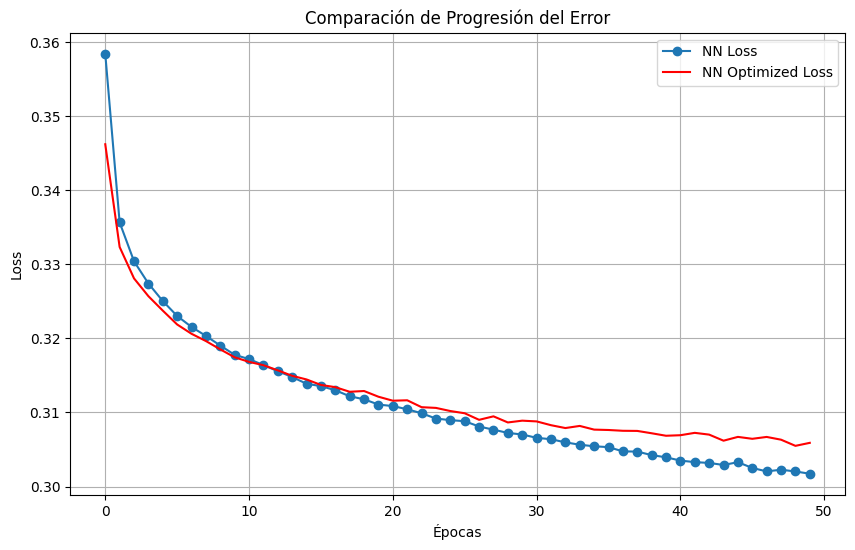

In [72]:
# Extraer los valores de pérdida
nn_optimized_loss = history_optimized['loss']  # Pérdida de la red neuronal

# Crear el gráfico
plt.figure(figsize=(10, 6))
plt.plot(nn_loss, label='NN Loss', marker='o')  # Progresión de la pérdida de la red neuronal
plt.plot(nn_optimized_loss, color='red', label='NN Optimized Loss')  # Línea horizontal para el modelo logístico

# Configurar el gráfico
plt.title('Comparación de Progresión del Error')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Interpretabilidad con los resultados obtenidos de Optuna en la red neuronal

In [ ]:
# Crear un explainer para tu modelo
explainer = shap.KernelExplainer(nn_model_optimized.model.predict, X_test_final[:100])  # Muestra para optimizar rendimiento

# Calcular valores SHAP
shap_values = explainer.shap_values(X_test_final)

# Visualización global
shap.summary_plot(shap_values, X_test_final)

# Visualización local para una instancia específica
index = 0  # Cambia el índice para ver otras instancias
shap.force_plot(explainer.expected_value, shap_values[index], X_test_final.iloc[index])


### Comparativa de modelos

In [ ]:
y_pred_automl = best_model.predict(X_test_final)
y_testy_pred_labels = ['Yes' if x == 1 else 'No' for x in y_pred_automl]
print(classification_report(y_test, y_testy_pred_labels))
y_pred_modelo_base = modelo_base.predict(X_test_final)
print(classification_report(y_test, y_pred_modelo_base))

y_pred_log = modelo.predict(X_test_final)
print(classification_report(y_test, y_pred_log))
f1_log = classification_report(y_test, y_pred_log, output_dict=True)['Yes']['f1-score']
f1_automl = classification_report(y_test, y_testy_pred_labels, output_dict=True)['Yes']['f1-score']
f1_modelo_base = classification_report(y_test, y_pred_modelo_base, output_dict=True)['Yes']['f1-score']
f1_nn = classification_report(y_test, y_pred_modelo_base, output_dict=True)['Yes']['f1-score']
metricas_f1 = {
    "LogisticRegression": f1_log,
    "Modelo Base" : f1_modelo_base,
    "AutoMl" : f1_automl,
    "NeuralNetwork" : f1_nn
}

mejor_modelo = max(metricas_f1, key=metricas_f1.get)
print("Mejor modelo según F1-score:",mejor_modelo)

### Serializar pipeline

In [ ]:
import joblib
joblib.dump(grid_search.best_estimator_, 'docker/pipeline.pkl')


### Conclusión

En este trabajo abordamos la predicción de lluvia en Australia mediante técnicas de aprendizaje automático. Partimos de un análisis exhaustivo del dataset weatherAUS.csv, que incluyó la exploración de variables, visualización de distribuciones, identificación y tratamiento de valores faltantes y atípicos, y la creación de nuevas variables como estaciones del año, tipos de lluvia, simplificación de direcciones del viento y clasificación por regiones a partir de clustering geográfico.

Para el modelado, se aplicaron diversos enfoques. Se entrenó un modelo base como referencia inicial, y luego modelos más complejos, entre los cuales se destaca la regresión logística. Esta se implementó dentro de un pipeline con StandardScaler, y se optimizaron hiperparámetros mediante GridSearchCV con validación cruzada. A partir de métrica F1-score y la matriz de confusión, observamos que la regresión logística obtuvo el mejor desempeño, aunque por una diferencia muy pequeña respecto a otros modelos evaluados.

Se trabajó también sobre explicabilidad utilizando la librería SHAP, aplicando análisis globales y locales para interpretar la influencia de las variables en las predicciones. Se identificaron las variables más relevantes y se analizaron sus contribuciones a nivel individual y general.

Respecto al punto de MLOps, se diseñó una solución reproducible y modular. Se entrenó el modelo final, se serializó el pipeline completo (pipeline.pkl) y se desarrolló un script de inferencia (inference.py) que carga nuevos datos, aplica transformaciones y genera predicciones. Todo este flujo fue empaquetado en un contenedor Docker mediante un Dockerfile, permitiendo que el sistema pueda ejecutarse en cualquier entorno con Docker instalado. Se incluyó también un archivo requirements.txt con las dependencias mínimas necesarias y un readme.md con instrucciones claras de uso.

En conclusión, logramos implementar un sistema completo de clasificación para predicción de lluvia, desde la limpieza y análisis del dataset hasta el entrenamiento, evaluación, explicabilidad y despliegue del modelo. Luego de mucho esfuerzo, se obtuvieron algunos resultados satisfactorios y otros no tanto, pero cada uno de ellos nos dejó aprender mediate la prueba y el error. Se dejó preparado el entorno para futuras mejoras, tanto en complejidad de modelos como en capacidades de producción.